# Confronto tra HGCN e GCN su tre dataset:
- Cora
- PubMed
- Albero bilanciato artificiale 3-ario di altezza 6

In [1]:
import os
import re
import matplotlib.pyplot as plt

stampa = False

def print_metrics(log, p=True):

    # Regex per estrarre i valori dalle righe nei log dei risultati prodotti dalla libreria 
    re_train = re.compile(
        r"Epoch:\s*(\d+).*?train_loss:\s*([0-9.]+)\s*train_roc:\s*([0-9.]+)\s*train_ap:\s*([0-9.]+)"
    )

    # Regex per righe di validation
    re_val = re.compile(
        r"Epoch:\s*(\d+).*?val_loss:\s*([0-9.]+)\s*val_roc:\s*([0-9.]+)\s*val_ap:\s*([0-9.]+)"
    )

    # Regex valori finali test
    re_test = re.compile(
        r"Test set results:\s*test_loss:\s*([0-9.]+)\s*test_roc:\s*([0-9.]+)\s*test_ap:\s*([0-9.]+)"
    )

    train_loss, train_roc, train_ap = [], [], []
    val_loss, val_roc, val_ap = [], [], []
    test_loss = test_roc = test_ap = 0.0

    with open(log, "r") as f:
        for line in f:
            m = re_train.search(line)
            if m:
                train_loss.append(float(m.group(2)))
                train_roc.append(float(m.group(3)))
                train_ap.append(float(m.group(4)))

            m = re_val.search(line)
            if m:
                val_loss.append(float(m.group(2)))
                val_roc.append(float(m.group(3)))
                val_ap.append(float(m.group(4)))

            m = re_test.search(line)
            if m:
                test_loss = float(m.group(1))
                test_roc  = float(m.group(2))
                test_ap   = float(m.group(3))

    epochs = list(range(1, len(train_loss)+1))
    if p :

        # ------------ GRAFICO TRAIN LOSS -------------------
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_loss)
        plt.title("Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid()
        plt.show()

        # ------------ GRAFICO TRAIN ROC + AP ---------------
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_roc, label="train_roc")
        plt.plot(epochs, val_roc,  label="val_roc")
        plt.title("Curva ROC")
        plt.xlabel("Epoch")
        plt.ylabel("ROC")
        plt.legend()
        plt.grid()
        plt.show()

        # ------------ GRAFICO VALIDATION ROC + AP ----------
        plt.figure(figsize=(10, 5))
        plt.plot(epochs, train_ap, label="train_ap")
        plt.plot(epochs, val_ap,  label="val_ap")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Acc")
        plt.legend()
        plt.grid()
        plt.show()

        # ------------ TEST RESULTS -----------------
    print("Test metrics finali:")
    print(f"  test_loss = {test_loss}")
    print(f"  test_roc  = {test_roc}")
    print(f"  test_ap   = {test_ap}")
    return train_roc, train_ap, val_roc, val_ap, test_roc, test_ap

cora = ["(lr 0.001, dim2)", "lr 0.00005", "lr 0.0005", "lr 0.005", "lr 0.01", "lr 0.05", "lr 0.09", "lr 0.12", "dim3", "dim4", "dim8", "dim10", "dim16", "dim20", "(lr 0.09, dim20)"]
pub =["(lr 0.001, dim2)", "lr 0.00005", "lr 0.0005", "lr 0.005", "lr 0.01", "lr 0.05", "lr 0.09", "lr 0.12", "dim3", "dim4", "dim8", "dim10", "dim16", "dim20", "(lr 0.05, dim20)"]
special = ["(lr 0.001, dim2)", "lr 0.00005", "lr 0.0005", "lr 0.005", "lr 0.01", "lr 0.05", "lr 0.09", "dim3", "dim4", "dim8", "dim10", "dim16", "dim20", "(lr 0.01, dim20)"]

# Parte senza usare le features
## HGCN su Cora (2708 nodi, 5278 archi)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "CORA con HGCN senza usare le features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_9_nofeatsCora"

all_train_roc, all_train_ap = [], []
all_val_roc, all_val_ap = [], []
all_test_roc, all_test_ap = [], []

for i in range(len(cora)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", cora[i], "\033[0m")
    out = print_metrics(log, False)
    
    embeddings = np.load(embeddings_path)

    all_train_roc.append(out[0])
    all_train_ap.append(out[1])
    all_val_roc.append(out[2])
    all_val_ap.append(out[3])
    all_test_roc.append(out[4])
    all_test_ap.append(out[5])

    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

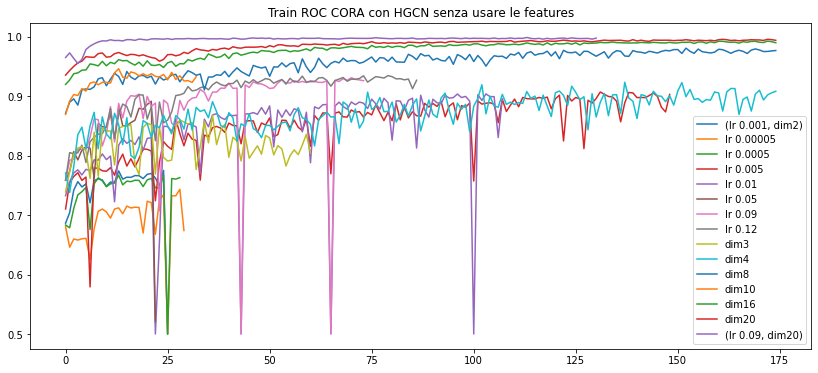

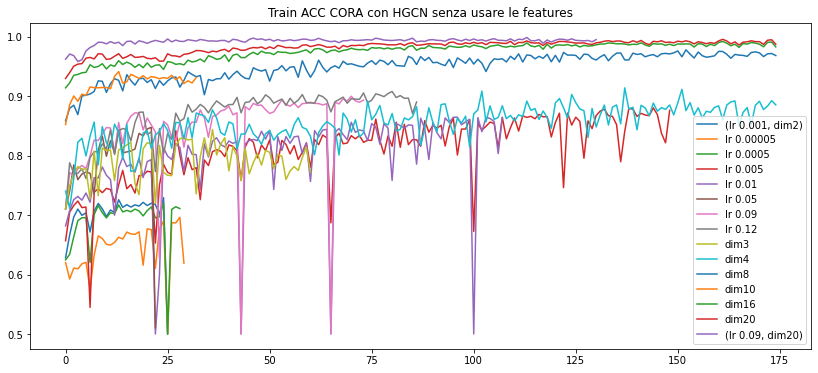

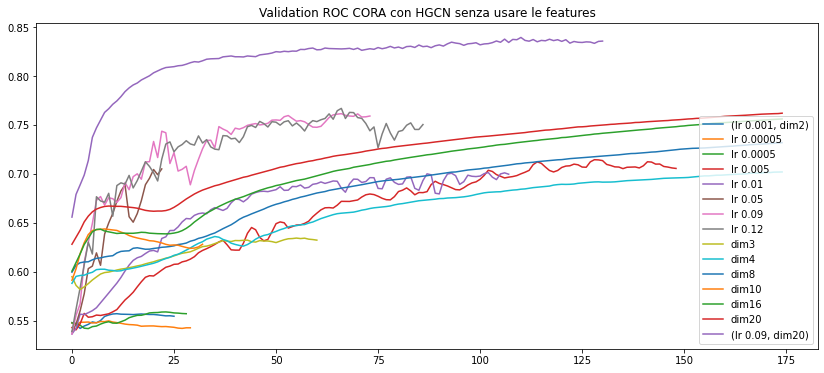

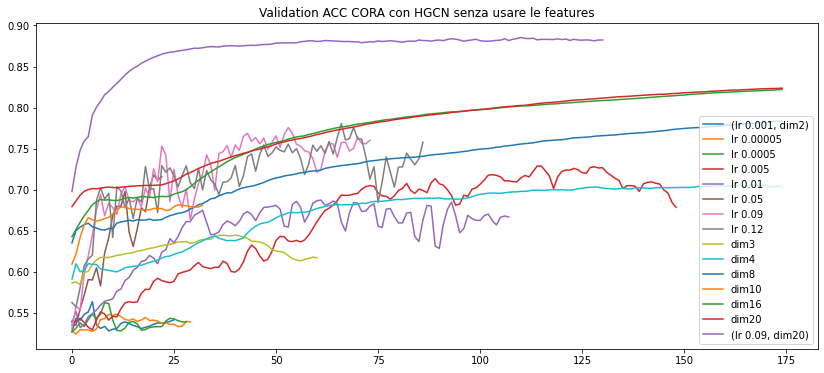

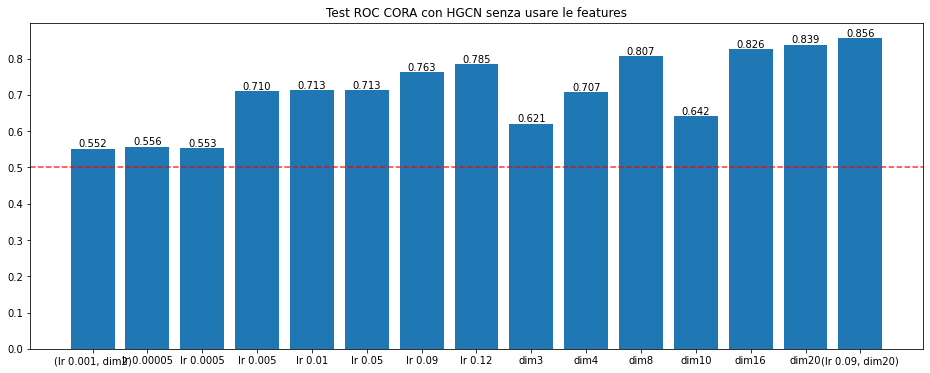

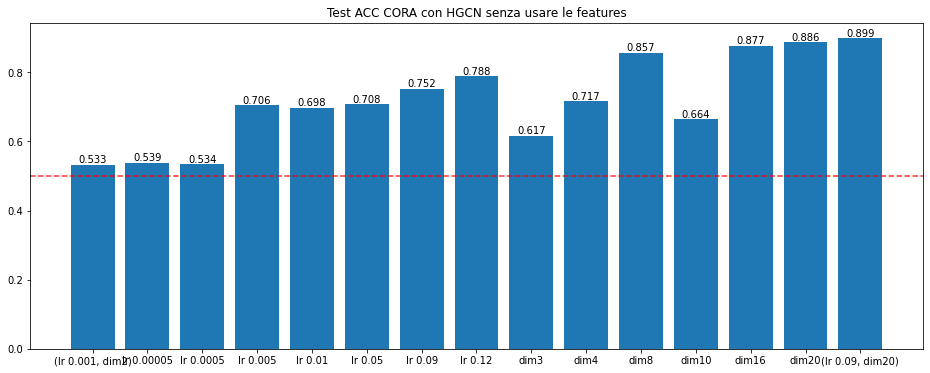

In [3]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc, all_train_ap, all_val_roc, all_val_ap]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=cora[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(cora, all_test_roc)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(cora, all_test_ap)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()
stampa = False

## GCN su Cora

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Cora con GCN e no features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_10_nofeatsCoraGCN"

all_train_roc2, all_train_ap2 = [], []
all_val_roc2, all_val_ap2 = [], []
all_test_roc2, all_test_ap2 = [], []

for i in range(len(cora)):  # cartelle da 0 a 10
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", cora[i], "\033[0m")
    out = print_metrics(log, False)
    

    all_train_roc2.append(out[0])
    all_train_ap2.append(out[1])
    all_val_roc2.append(out[2])
    all_val_ap2.append(out[3])
    all_test_roc2.append(out[4])
    all_test_ap2.append(out[5])

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    embeddings = np.load(embeddings_path)
    
    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

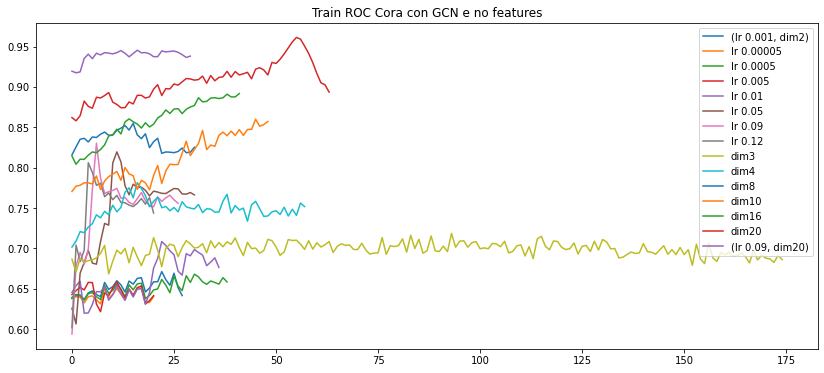

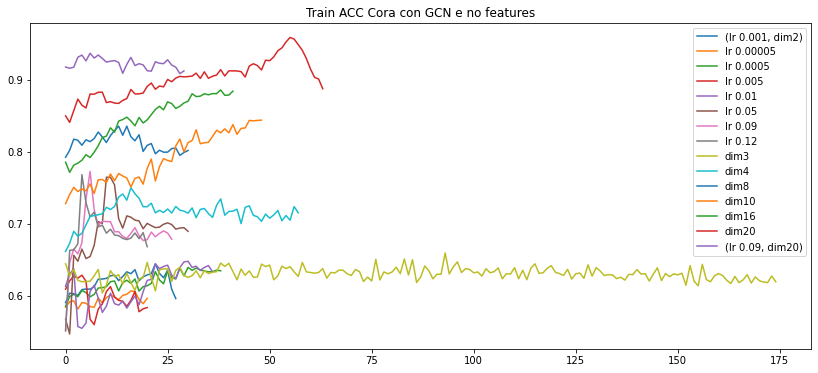

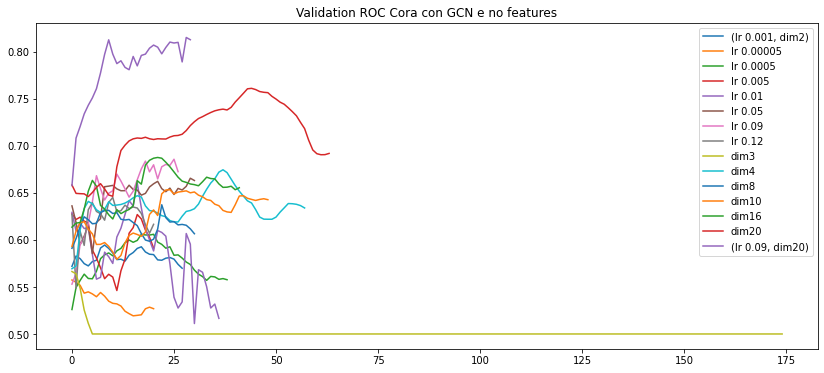

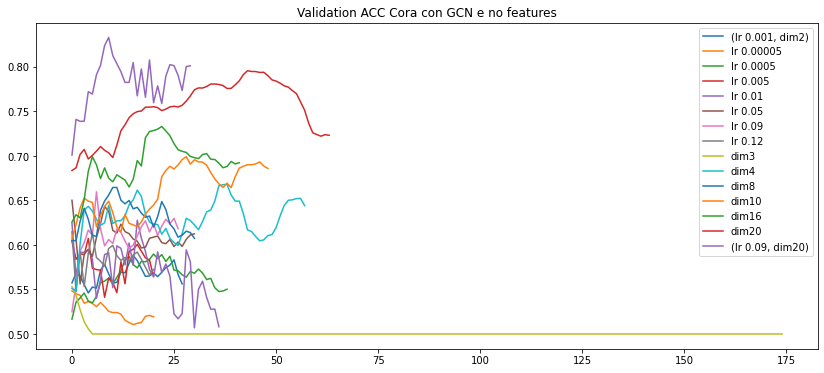

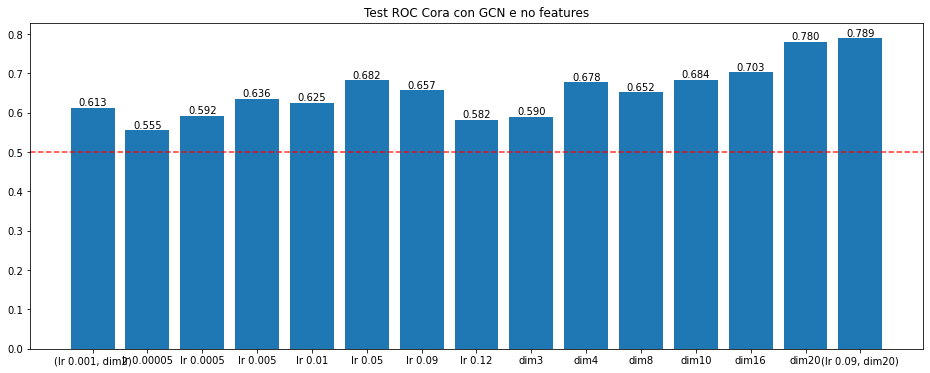

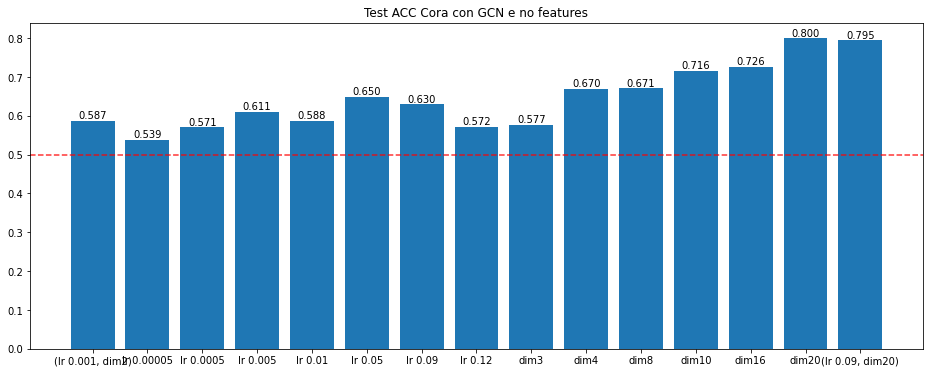

In [5]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc2, all_train_ap2, all_val_roc2, all_val_ap2]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=cora[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(cora, all_test_roc2)

    # Aggiungere etichette sopra le barre
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(cora, all_test_ap2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

## Confronto HGCN vs GCN

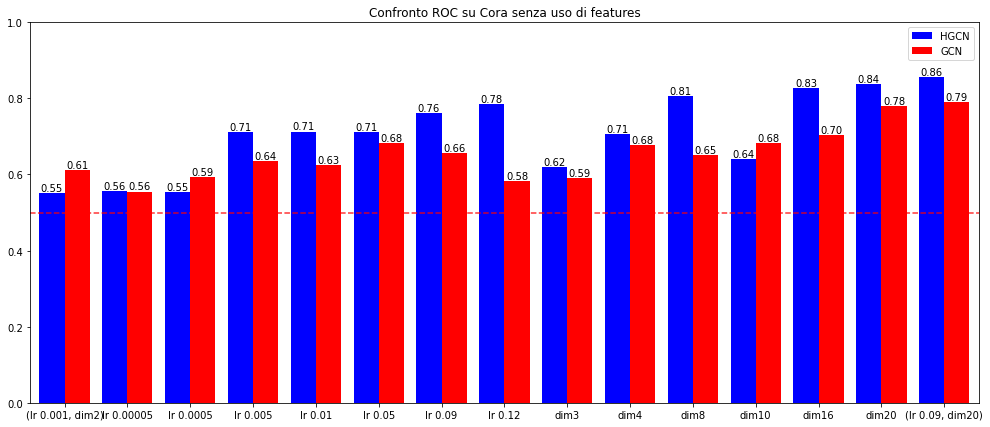

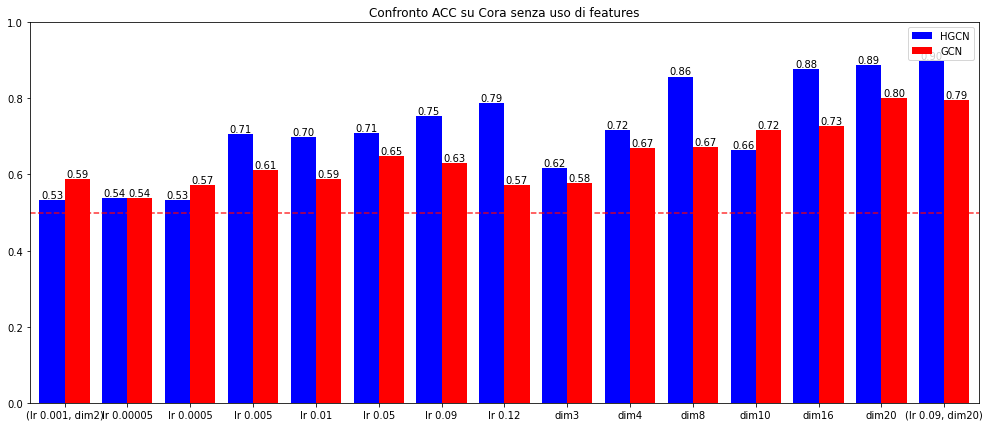

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(cora))
width = 0.4

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ROC su Cora senza uso di features")

bars1 = plt.bar(x - width/2, all_test_roc, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_roc2, width, label='GCN', color='red')

plt.xticks(x, cora)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.margins(x=0.01)
plt.ylim([0, 1])
plt.show()

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ACC su Cora senza uso di features")

bars1 = plt.bar(x - width/2, all_test_ap, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_ap2, width, label='GCN', color='red')

plt.xticks(x, cora)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.margins(x=0.01)
plt.ylim([0, 1])
plt.show()

In [7]:
z1 = []
z2 = []

for a, b in zip(all_test_ap, all_test_ap2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z1.append(diff_percent)
    else:
        print("Errore: divisione per zero")

for a, b in zip(all_test_roc, all_test_roc2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z2.append(diff_percent)
    else:
        print("Errore: divisione per zero")

print(f"La percentuale di guadagno di HGCN rispetto a GCN è:\n-Su ACC: {np.mean(z1):.2f}%\n-Su ROC: {np.mean(z2):.2f}%")
print(f"\nMaggior guadagno:\n-ACC: {cora[np.argmin(z1)]} ({np.min(z1):.2f})\n-ROC: {cora[np.argmin(z2)]} ({np.min(z2):.2f})")
print(f"\nMinor guadagno:\n-ACC: {cora[np.argmax(z1)]} ({np.max(z1):.2f})\n-ROC: {cora[np.argmax(z2)]} ({np.max(z2):.2f})")

La percentuale di guadagno di HGCN rispetto a GCN è:
-Su ACC: -8.63%
-Su ROC: -6.70%

Maggior guadagno:
-ACC: lr 0.12 (-27.48)
-ROC: lr 0.12 (-25.88)

Minor guadagno:
-ACC: (lr 0.001, dim2) (10.23)
-ROC: (lr 0.001, dim2) (10.98)


## HGCN su PubMed (19717 nodi e 44327 archi, ≈ 3GB)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "PubMed con HGCN senza usare le features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_9_nofeatsPubmed"

all_train_roc, all_train_ap = [], []
all_val_roc, all_val_ap = [], []
all_test_roc, all_test_ap = [], []

for i in range(len(pub)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", pub[i], "\033[0m")
    out = print_metrics(log, False)
    
    embeddings = np.load(embeddings_path)

    all_train_roc.append(out[0])
    all_train_ap.append(out[1])
    all_val_roc.append(out[2])
    all_val_ap.append(out[3])
    all_test_roc.append(out[4])
    all_test_ap.append(out[5])

    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

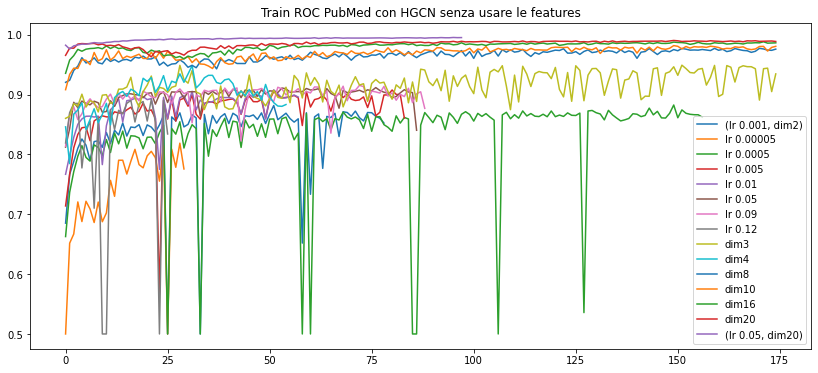

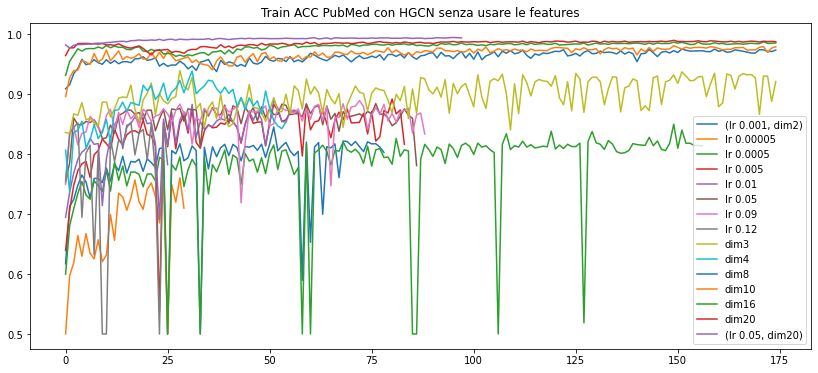

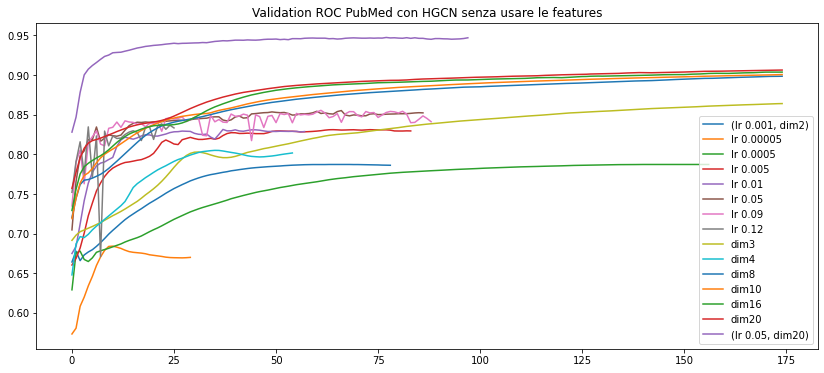

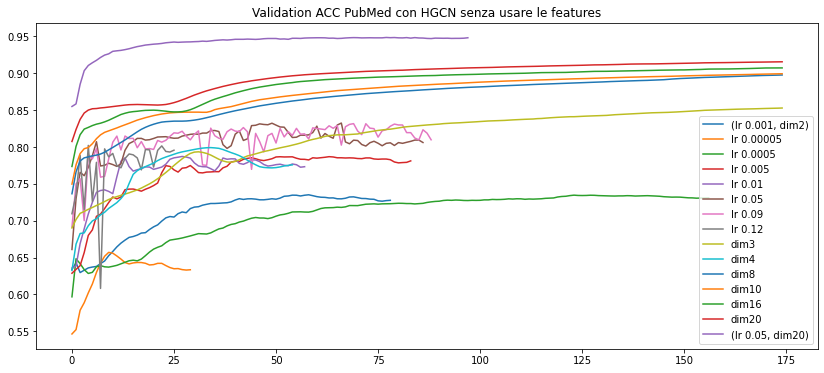

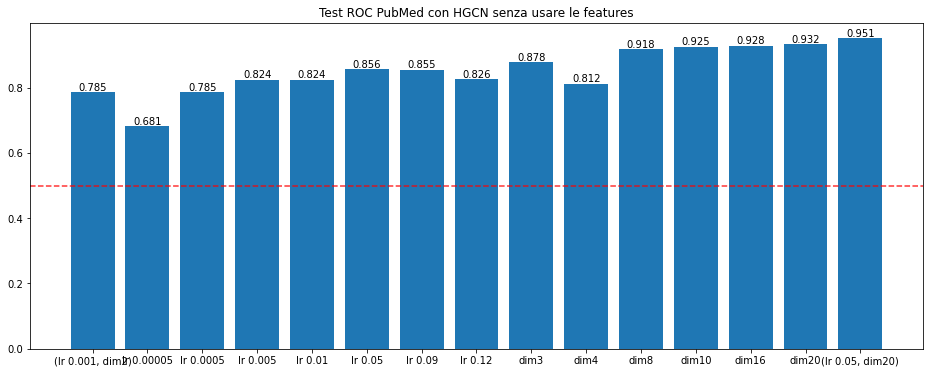

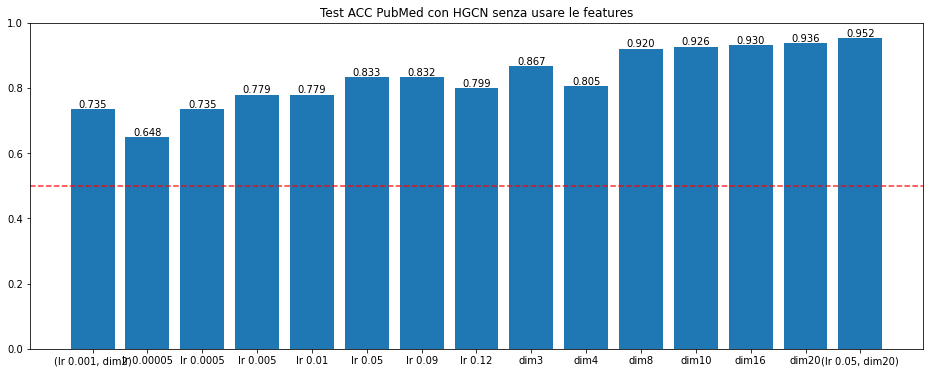

In [9]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc, all_train_ap, all_val_roc, all_val_ap]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=pub[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(pub, all_test_roc)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(pub, all_test_ap)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()
stampa = False

## GCN su PubMed

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Pubmed con GCN e no features"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_10_nofeatsPubmedGCN"

all_train_roc2, all_train_ap2 = [], []
all_val_roc2, all_val_ap2 = [], []
all_test_roc2, all_test_ap2 = [], []

for i in range(len(pub)):  # cartelle da 0 a 10
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", pub[i], "\033[0m")
    out = print_metrics(log, False)
    

    all_train_roc2.append(out[0])
    all_train_ap2.append(out[1])
    all_val_roc2.append(out[2])
    all_val_ap2.append(out[3])
    all_test_roc2.append(out[4])
    all_test_ap2.append(out[5])

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    embeddings = np.load(embeddings_path)
    
    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

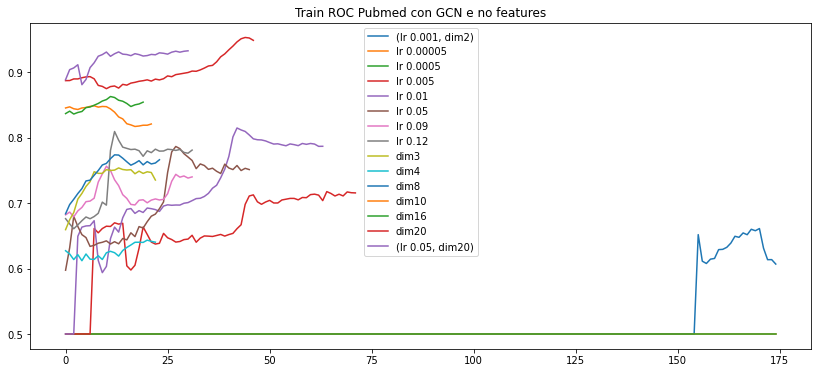

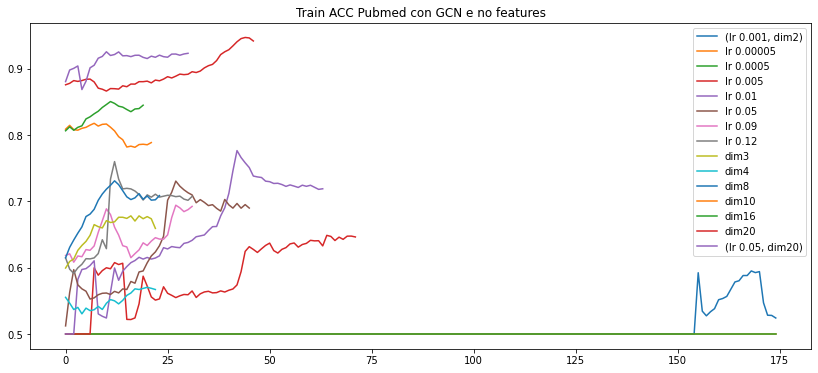

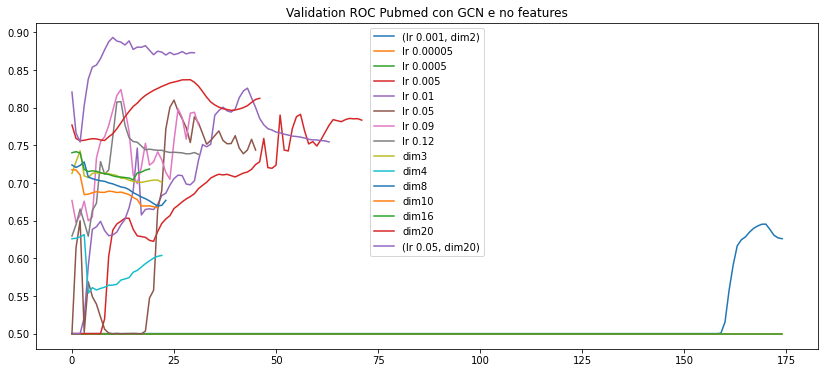

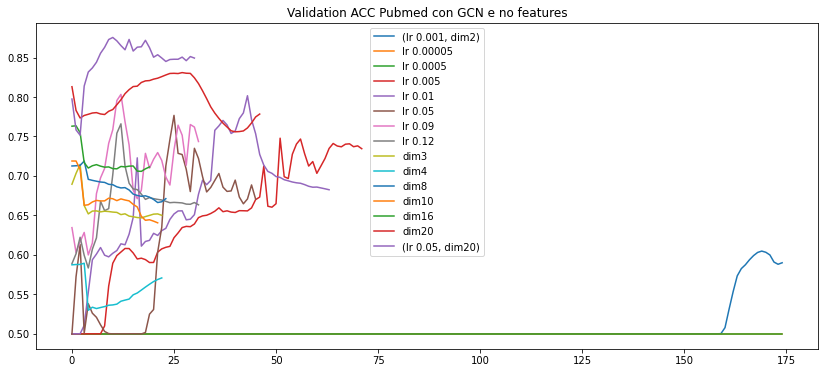

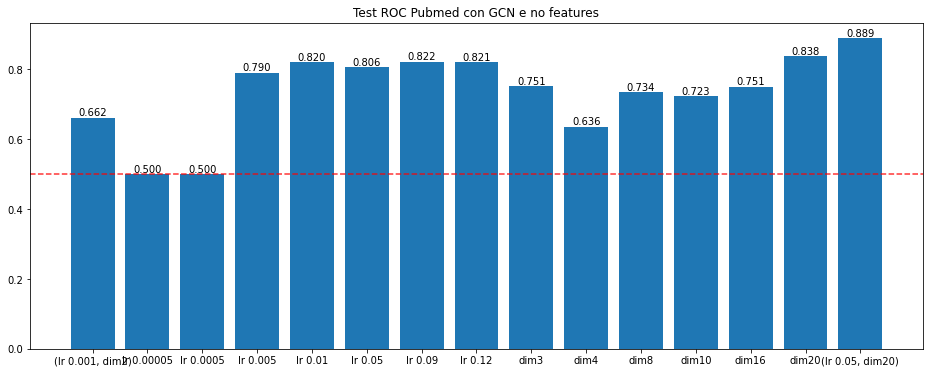

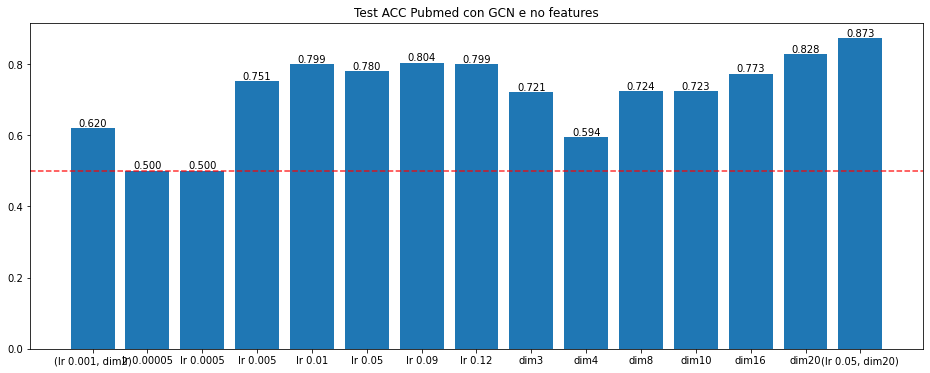

In [11]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc2, all_train_ap2, all_val_roc2, all_val_ap2]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=pub[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(pub, all_test_roc2)

    # Aggiungere etichette sopra le barre
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(pub, all_test_ap2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

## Confronto HGCN vs GCN

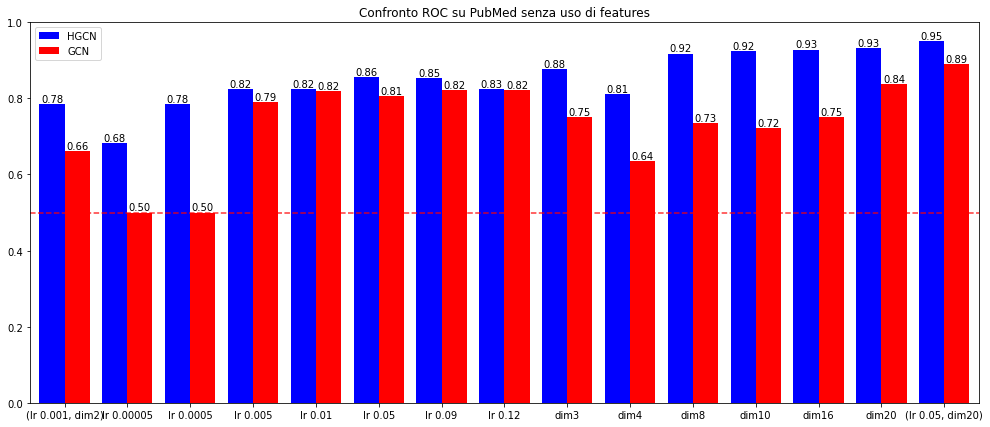

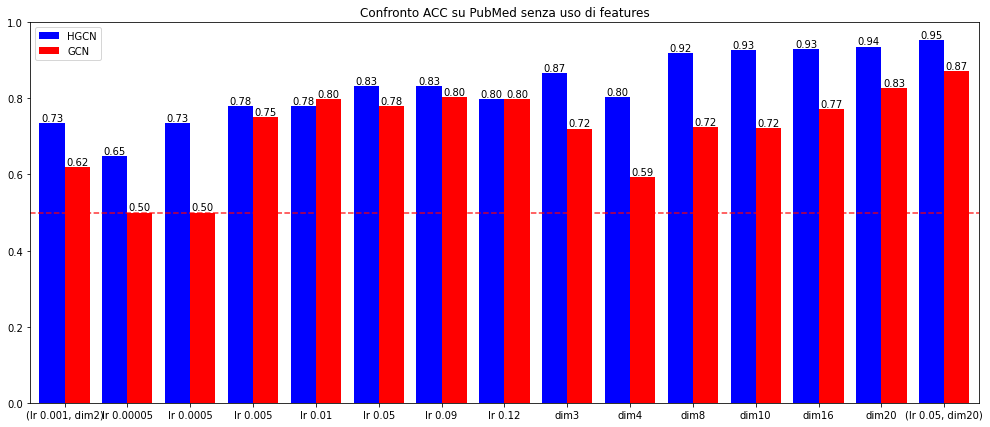

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(pub))
width = 0.4

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ROC su PubMed senza uso di features")

bars1 = plt.bar(x - width/2, all_test_roc, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_roc2, width, label='GCN', color='red')

plt.xticks(x, pub)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.margins(x=0.01)
plt.ylim([0, 1])
plt.show()

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ACC su PubMed senza uso di features")

bars1 = plt.bar(x - width/2, all_test_ap, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_ap2, width, label='GCN', color='red')

plt.xticks(x, pub)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.margins(x=0.01)
plt.ylim([0, 1])
plt.show()

In [13]:
z1 = []
z2 = []

for a, b in zip(all_test_ap, all_test_ap2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z1.append(diff_percent)
    else:
        print("Errore: divisione per zero")

for a, b in zip(all_test_roc, all_test_roc2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z2.append(diff_percent)
    else:
        print("Errore: divisione per zero")

print(f"La percentuale di guadagno di HGCN rispetto a GCN è:\n-Su ACC: {np.mean(z1):.2f}%\n-Su ROC: {np.mean(z2):.2f}%")
print(f"\nMaggior guadagno:\n-ACC: {pub[np.argmin(z1)]} ({np.min(z1):.2f})\n-ROC: {pub[np.argmin(z2)]} ({np.min(z2):.2f})")
print(f"\nMinor guadagno:\n-ACC: {pub[np.argmax(z1)]} ({np.max(z1):.2f})\n-ROC: {pub[np.argmax(z2)]} ({np.max(z2):.2f})")

La percentuale di guadagno di HGCN rispetto a GCN è:
-Su ACC: -13.62%
-Su ROC: -13.79%

Maggior guadagno:
-ACC: lr 0.0005 (-31.95)
-ROC: lr 0.0005 (-36.29)

Minor guadagno:
-ACC: lr 0.01 (2.55)
-ROC: lr 0.01 (-0.49)


# Albero artificiale senza features (r=3 e p=6, 1093 nodi e 1092 archi)

## HGCN su albero

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Albero artificiale"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_4_nofeatsTreeHGCN"

all_train_roc, all_train_ap = [], []
all_val_roc, all_val_ap = [], []
all_test_roc, all_test_ap = [], []

for i in range(len(special)):  # cartelle da 0 a 10
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", special[i], "\033[0m")
    out = print_metrics(log, False)
    

    all_train_roc.append(out[0])
    all_train_ap.append(out[1])
    all_val_roc.append(out[2])
    all_val_ap.append(out[3])
    all_test_roc.append(out[4])
    all_test_ap.append(out[5])

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    embeddings = np.load(embeddings_path)
    
    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

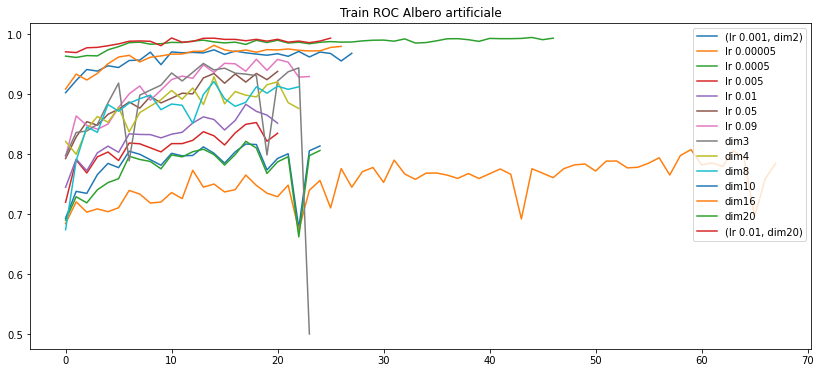

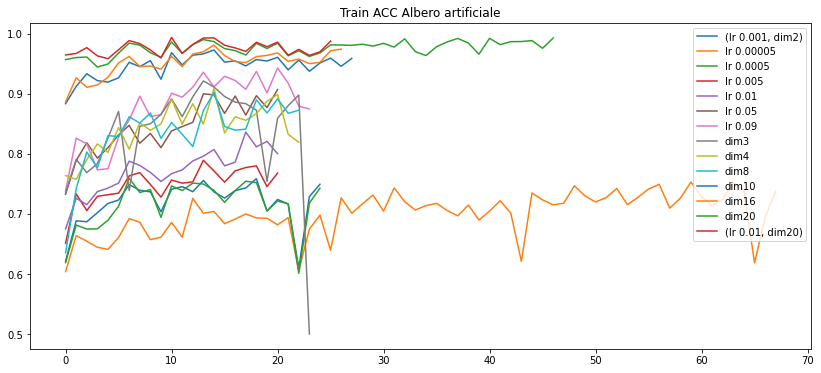

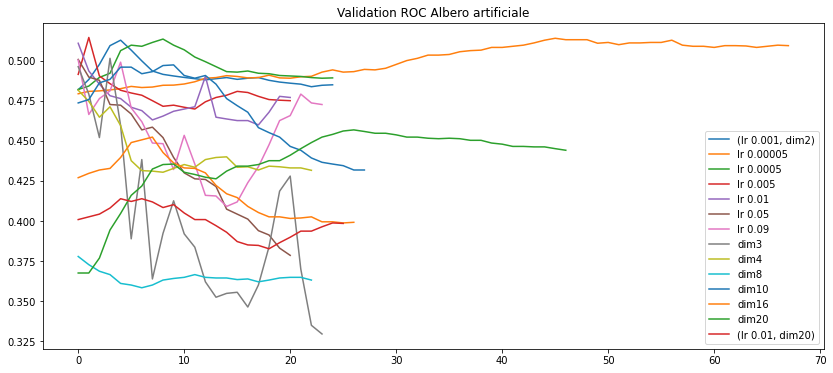

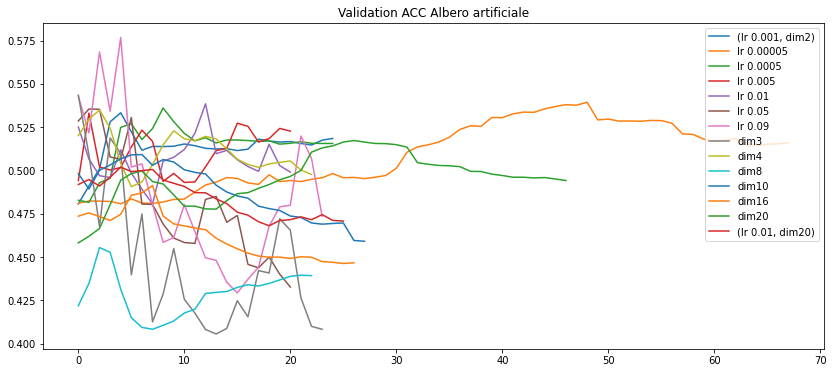

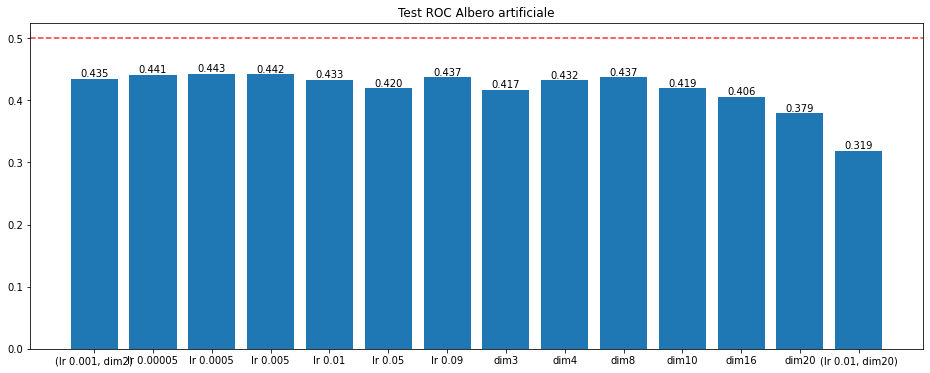

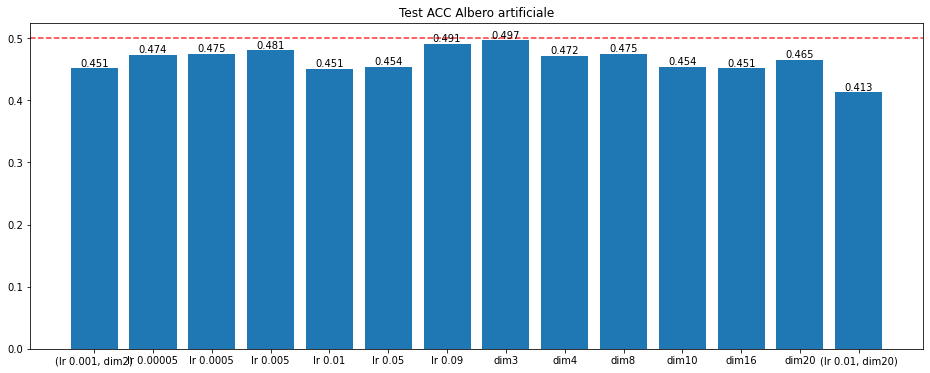

In [15]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc, all_train_ap, all_val_roc, all_val_ap]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=special[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(special, all_test_roc)

    # Aggiungere etichette sopra le barre
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(special, all_test_ap)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

## GCN su albero

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Albero artificiale bilanciato (r=3, h=6) (1092 archi, 1093 nodi)"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_7_nofeatsTreeGCN"

all_train_roc2, all_train_ap2 = [], []
all_val_roc2, all_val_ap2 = [], []
all_test_roc2, all_test_ap2 = [], []

for i in range(len(special)):  # cartelle da 0 a 10
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", special[i], "\033[0m")
    out = print_metrics(log, True)
    

    all_train_roc2.append(out[0])
    all_train_ap2.append(out[1])
    all_val_roc2.append(out[2])
    all_val_ap2.append(out[3])
    all_test_roc2.append(out[4])
    all_test_ap2.append(out[5])

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    embeddings = np.load(embeddings_path)
    
    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

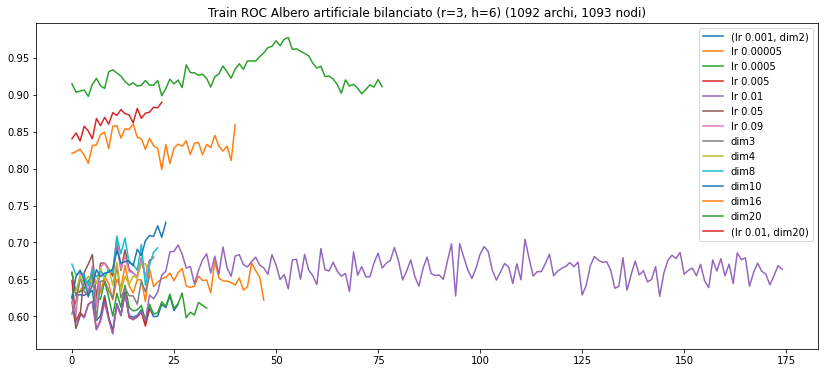

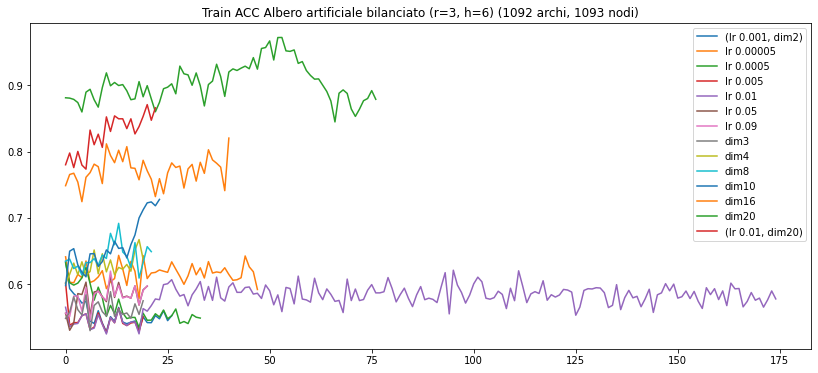

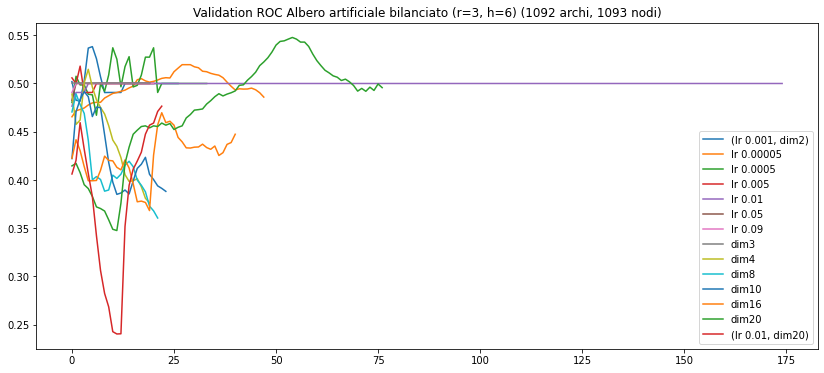

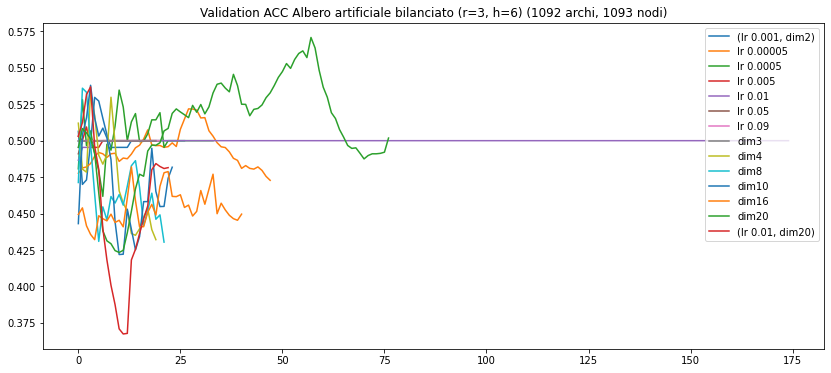

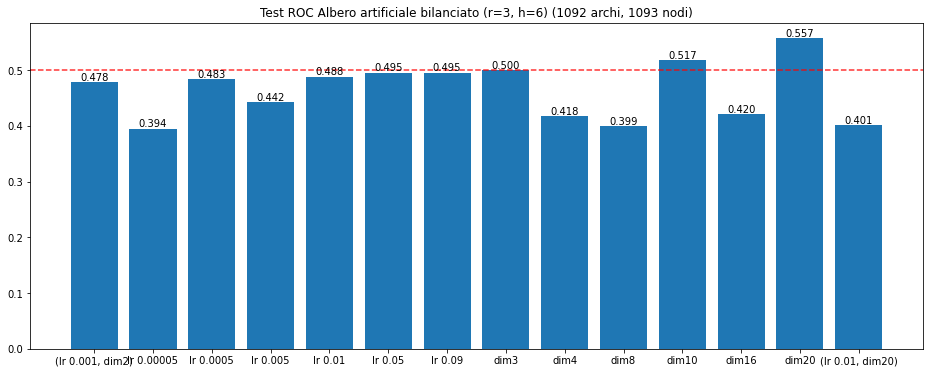

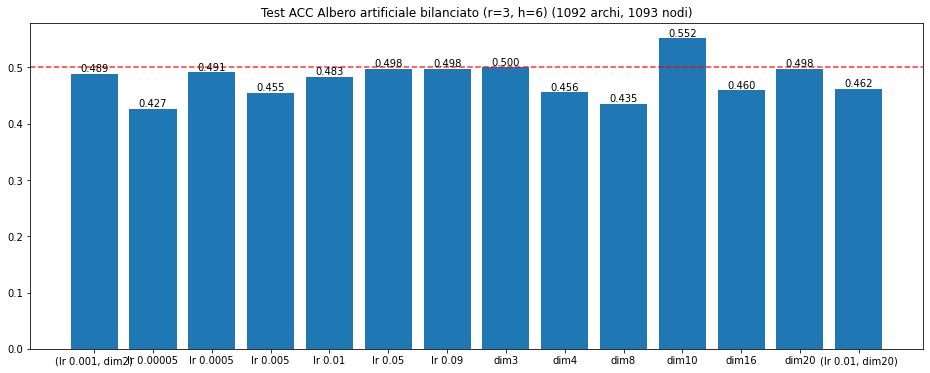

In [17]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc2, all_train_ap2, all_val_roc2, all_val_ap2]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=special[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(special, all_test_roc2)

    # Aggiungere etichette sopra le barre
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(special, all_test_ap2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

## Confronto HGCN vs GCN

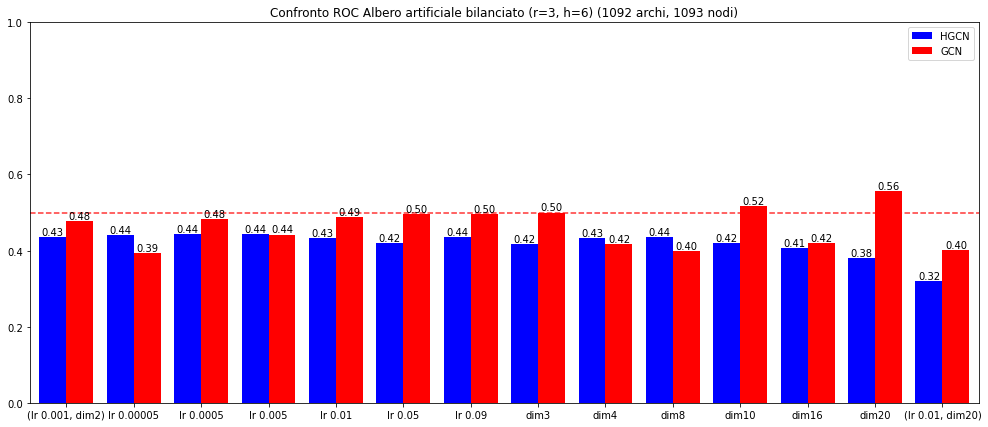

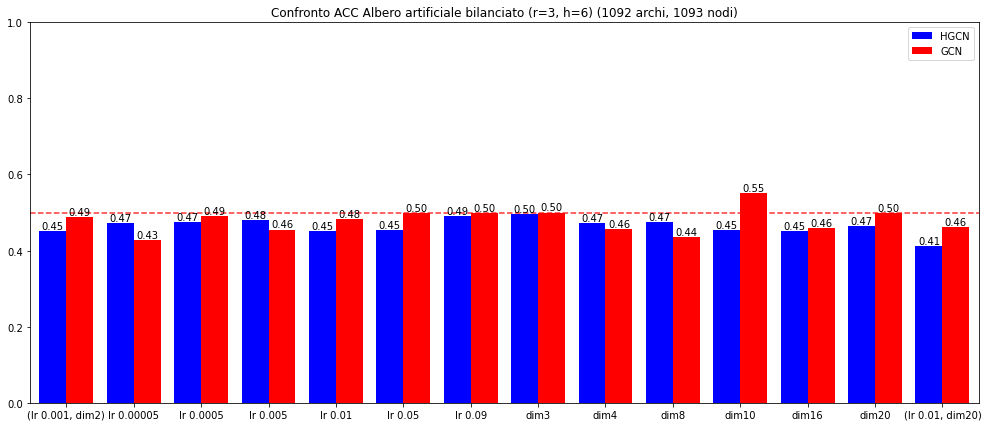

In [18]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(special))
width = 0.4

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ROC " + dataset)

bars1 = plt.bar(x - width/2, all_test_roc, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_roc2, width, label='GCN', color='red')

plt.xticks(x, special)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.margins(x=0.01)
plt.ylim([0, 1])
plt.show()

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ACC " + dataset)

bars1 = plt.bar(x - width/2, all_test_ap, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_ap2, width, label='GCN', color='red')

plt.xticks(x, special)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )
plt.margins(x=0.01)
plt.ylim([0, 1])
plt.show()

In [19]:
z1 = []
z2 = []

for a, b in zip(all_test_ap, all_test_ap2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z1.append(diff_percent)
    else:
        print("Errore: divisione per zero")

for a, b in zip(all_test_roc, all_test_roc2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z2.append(diff_percent)
    else:
        print("Errore: divisione per zero")

print(f"La percentuale di guadagno di HGCN rispetto a GCN è:\n-Su ACC: {np.mean(z1):.2f}%\n-Su ROC: {np.mean(z2):.2f}%")
print(f"\nMaggior guadagno:\n-ACC: {special[np.argmin(z1)]} ({np.min(z1):.2f})\n-ROC: {special[np.argmin(z2)]} ({np.min(z2):.2f})")
print(f"\nMinor guadagno:\n-ACC: {special[np.argmax(z1)]} ({np.max(z1):.2f})\n-ROC: {special[np.argmax(z2)]} ({np.max(z2):.2f})")

La percentuale di guadagno di HGCN rispetto a GCN è:
-Su ACC: 3.30%
-Su ROC: 11.46%

Maggior guadagno:
-ACC: lr 0.00005 (-9.88)
-ROC: lr 0.00005 (-10.65)

Minor guadagno:
-ACC: dim10 (21.53)
-ROC: dim20 (46.90)


# Utilizzando le features dei nodi
## Usando HGCN su Cora (2708 nodi, 5278 archi)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "CORA con HGCN"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_11_25"

all_train_roc, all_train_ap = [], []
all_val_roc, all_val_ap = [], []
all_test_roc, all_test_ap = [], []

for i in range(len(cora)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", cora[i], "\033[0m")
    out = print_metrics(log, False)
    
    embeddings = np.load(embeddings_path)

    all_train_roc.append(out[0])
    all_train_ap.append(out[1])
    all_val_roc.append(out[2])
    all_val_ap.append(out[3])
    all_test_roc.append(out[4])
    all_test_ap.append(out[5])

    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

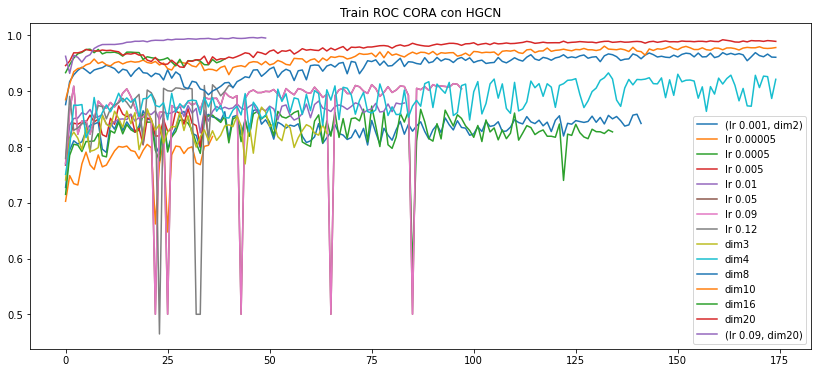

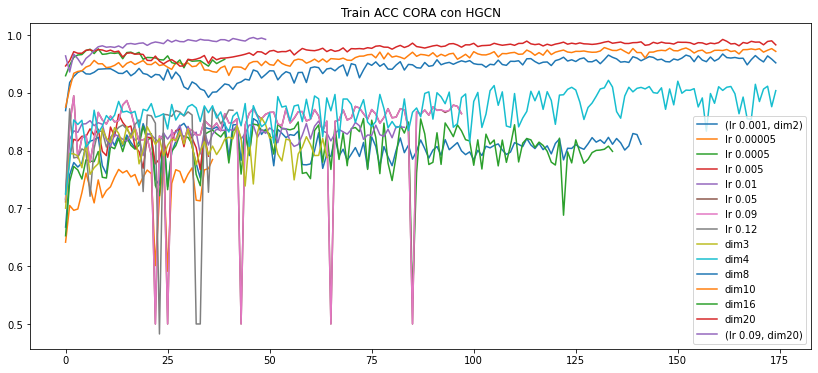

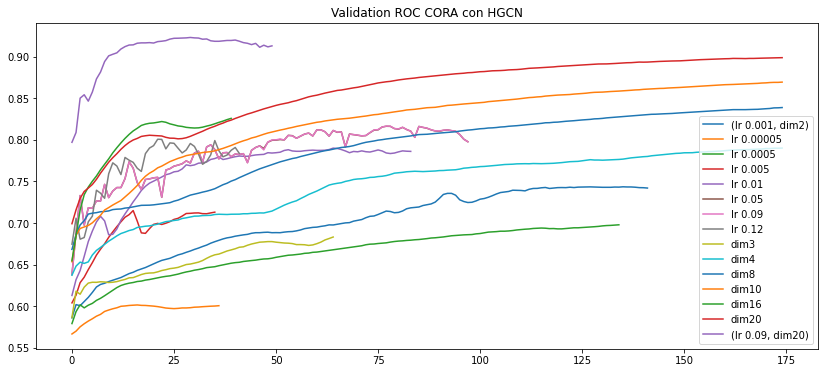

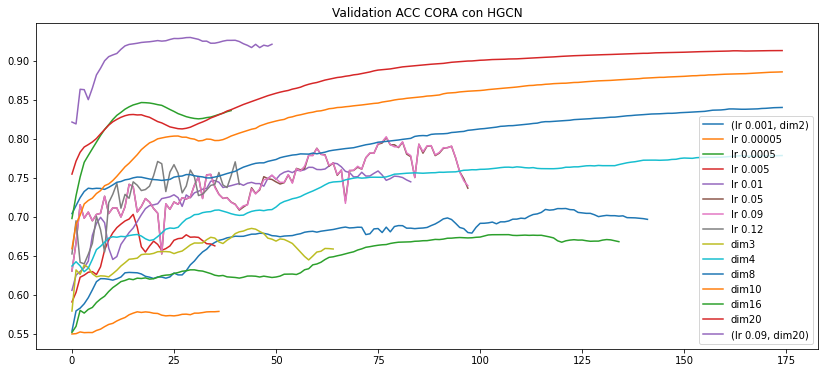

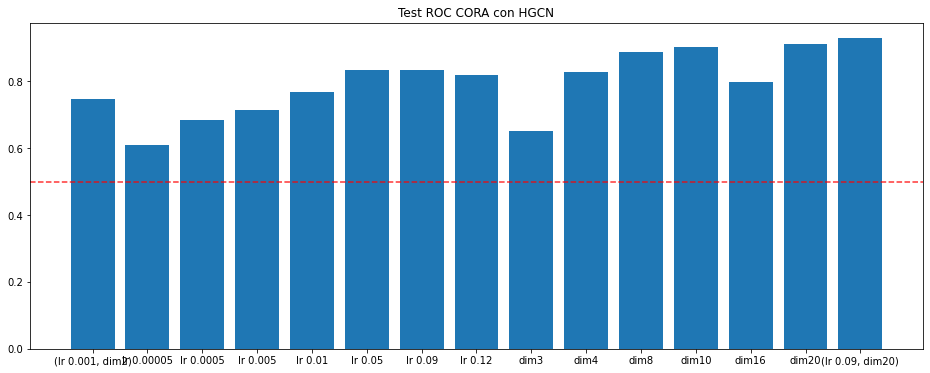

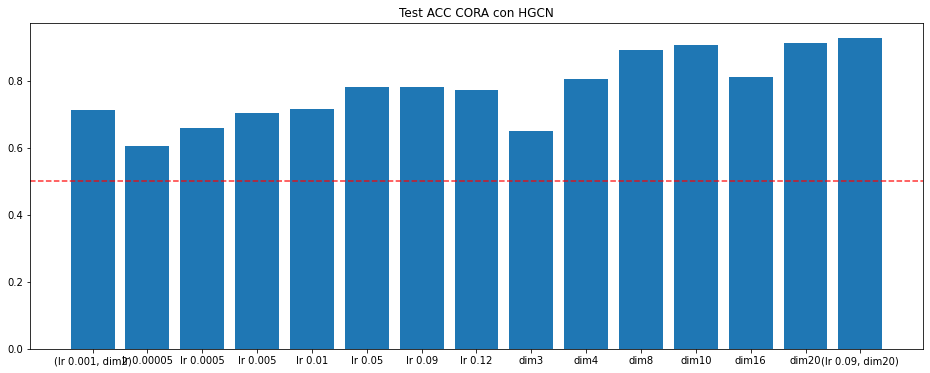

In [21]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc, all_train_ap, all_val_roc, all_val_ap]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j] + " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=cora[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)
    plt.bar(cora, all_test_roc)
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)
    plt.bar(cora, all_test_ap)
    plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "CORA con GCN"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_7_coraGCN"

all_train_roc2, all_train_ap2 = [], []
all_val_roc2, all_val_ap2 = [], []
all_test_roc2, all_test_ap2 = [], []

for i in range(len(cora)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", cora[i], "\033[0m")
    out = print_metrics(log, False)    

    all_train_roc2.append(out[0])
    all_train_ap2.append(out[1])
    all_val_roc2.append(out[2])
    all_val_ap2.append(out[3])
    all_test_roc2.append(out[4])
    all_test_ap2.append(out[5])
    
    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    
    embeddings = np.load(embeddings_path)
    
    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

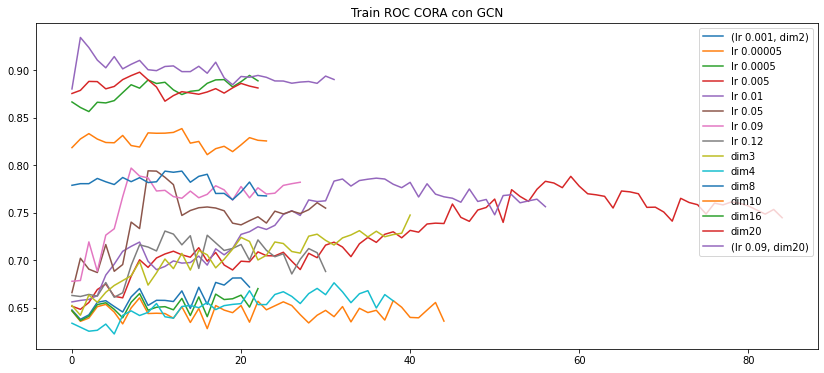

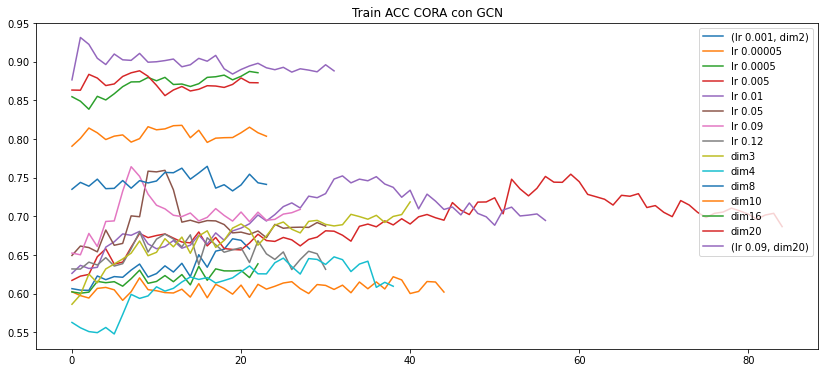

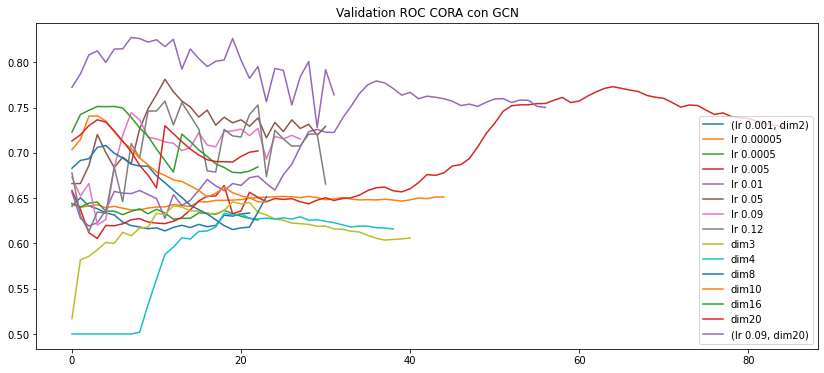

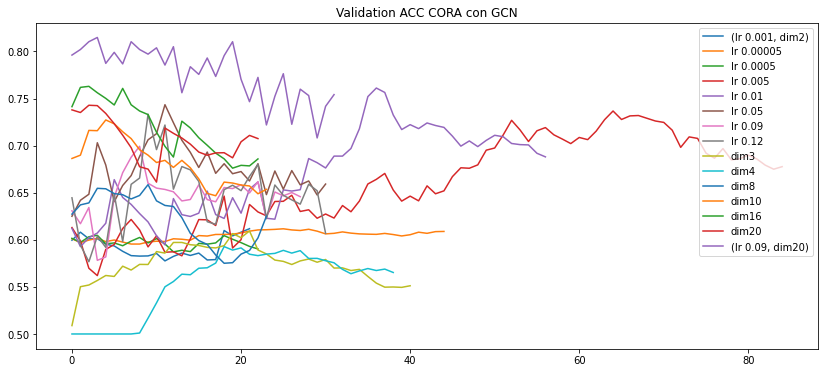

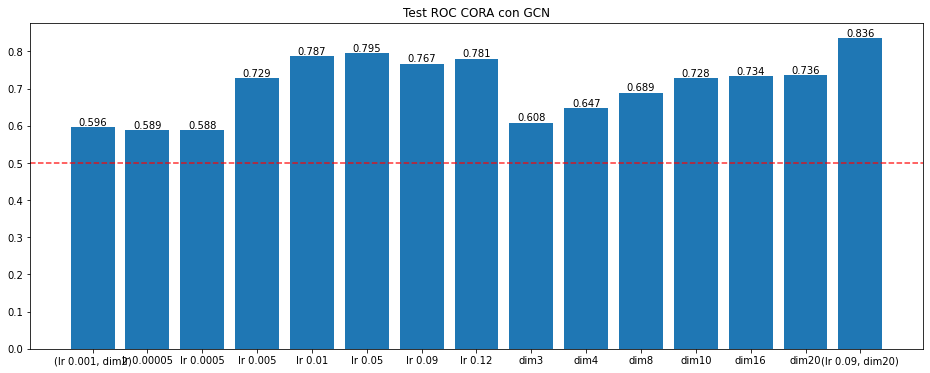

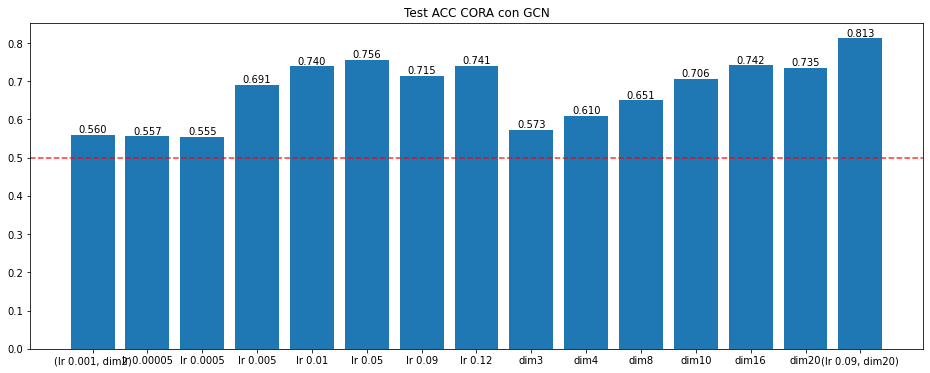

In [23]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc2, all_train_ap2, all_val_roc2, all_val_ap2]

stmpa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j] + " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=cora[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(cora, all_test_roc2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(cora, all_test_ap2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

# Confronto diretto HGCN vs GCN

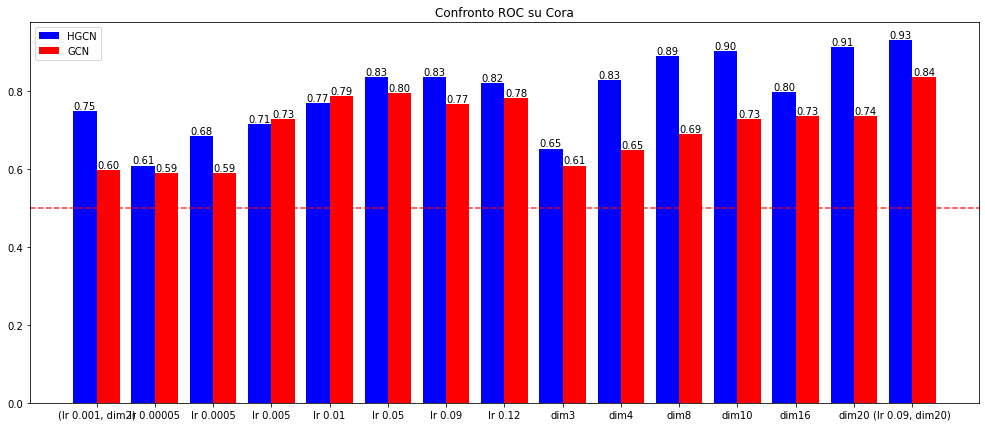

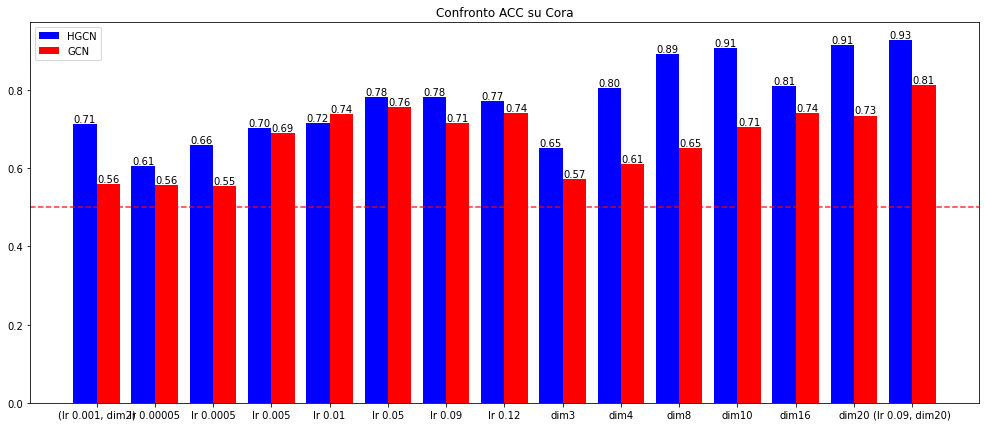

In [24]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(cora))
width = 0.4

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ROC su Cora")

bars1 = plt.bar(x - width/2, all_test_roc, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_roc2, width, label='GCN', color='red')

plt.xticks(x, cora)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.show()

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ACC su Cora")

bars1 = plt.bar(x - width/2, all_test_ap, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_ap2, width, label='GCN', color='red')

plt.xticks(x, cora)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.show()

In [25]:
z1 = []
z2 = []

for a, b in zip(all_test_ap, all_test_ap2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z1.append(diff_percent)
    else:
        print("Errore: divisione per zero")

for a, b in zip(all_test_roc, all_test_roc2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z2.append(diff_percent)
    else:
        print("Errore: divisione per zero")

print(f"La percentuale di guadagno di HGCN rispetto a GCN è:\n-Su ACC: {np.mean(z1):.2f}%\n-Su ROC: {np.mean(z2):.2f}%")
print(f"\nMaggior guadagno:\n-ACC: {cora[np.argmin(z1)]}\n-ROC: {cora[np.argmin(z2)]}")
print(f"\nMinor guadagno:\n-ACC: {cora[np.argmax(z1)]}\n-ROC: {cora[np.argmax(z2)]}")

La percentuale di guadagno di HGCN rispetto a GCN è:
-Su ACC: -12.40%
-Su ROC: -10.54%

Maggior guadagno:
-ACC: dim8
-ROC: dim8

Minor guadagno:
-ACC: lr 0.01
-ROC: lr 0.01


## Usando HGCN su PubMed (19717 nodi e 44327 archi, ≈ 3GB)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "PubMed"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_11_26_pubmed"

all_train_roc, all_train_ap = [], []
all_val_roc, all_val_ap = [], []
all_test_roc, all_test_ap = [], []

for i in range(len(pub)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", pub[i], "\033[0m")
    out = print_metrics(log, False)
    
    embeddings = np.load(embeddings_path)

    all_train_roc.append(out[0])
    all_train_ap.append(out[1])
    all_val_roc.append(out[2])
    all_val_ap.append(out[3])
    all_test_roc.append(out[4])
    all_test_ap.append(out[5])

    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

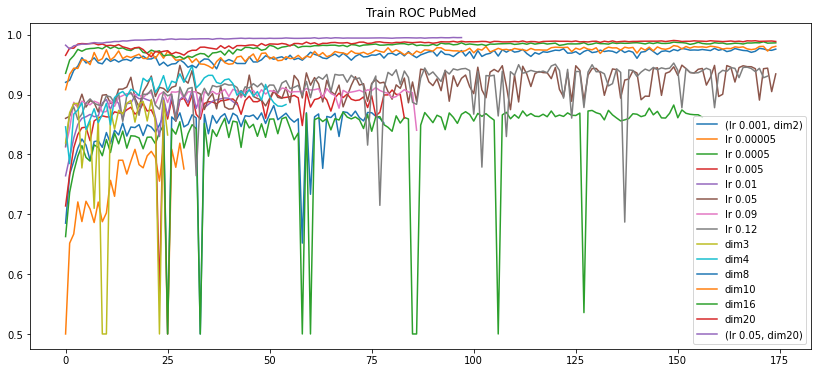

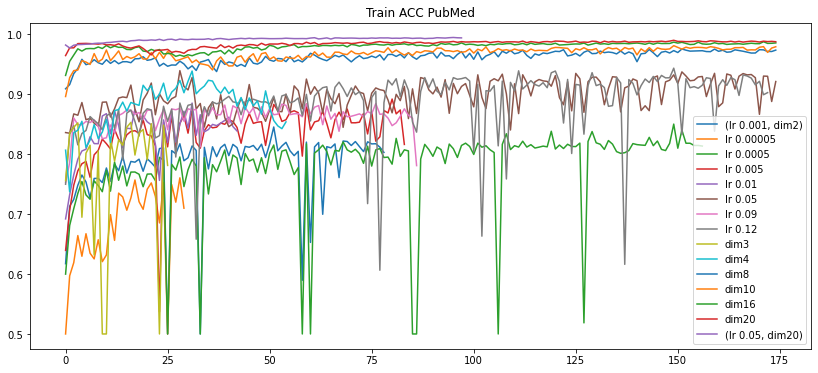

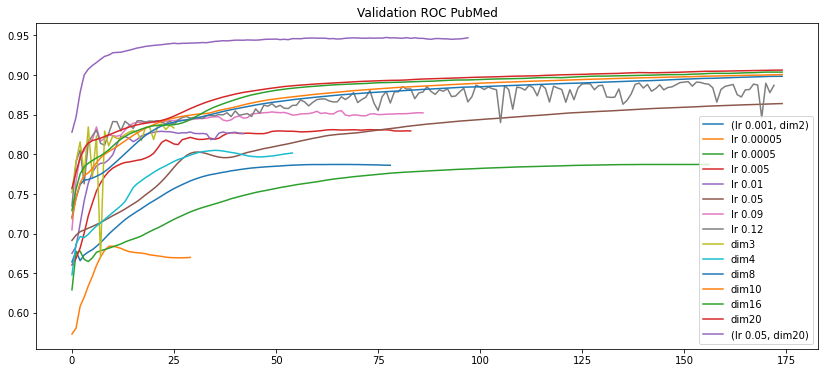

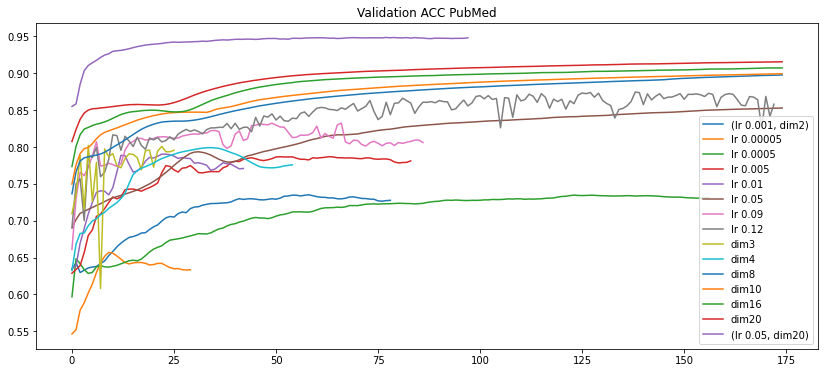

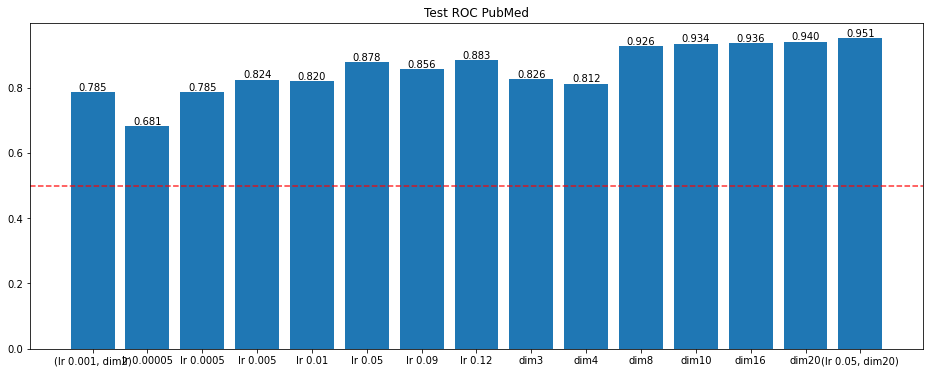

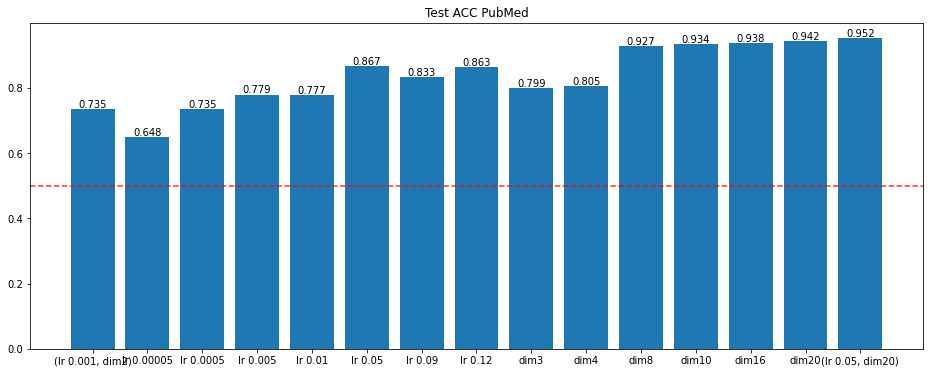

In [27]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc, all_train_ap, all_val_roc, all_val_ap]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=pub[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(pub, all_test_roc)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(pub, all_test_ap)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

## Ora con GCN (pubmed)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "PubMed"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_7_pubmedGCN"

all_train_roc2, all_train_ap2 = [], []
all_val_roc2, all_val_ap2 = [], []
all_test_roc2, all_test_ap2 = [], []

for i in range(len(pub)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", pub[i], "\033[0m")
    out = print_metrics(log, False)
    

    all_train_roc2.append(out[0])
    all_train_ap2.append(out[1])
    all_val_roc2.append(out[2])
    all_val_ap2.append(out[3])
    all_test_roc2.append(out[4])
    all_test_ap2.append(out[5])

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    embeddings = np.load(embeddings_path)
    
    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

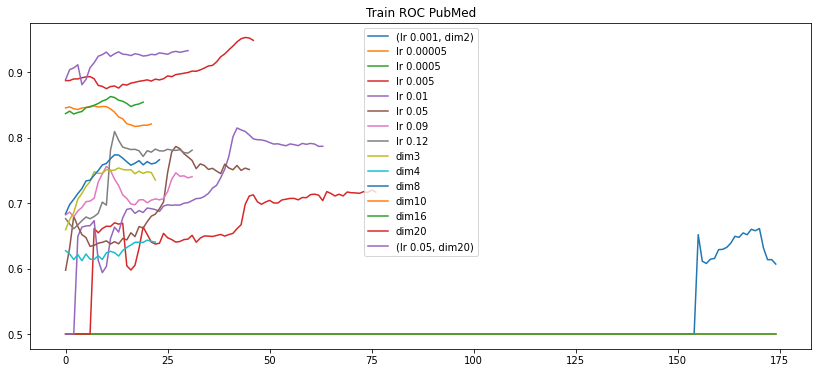

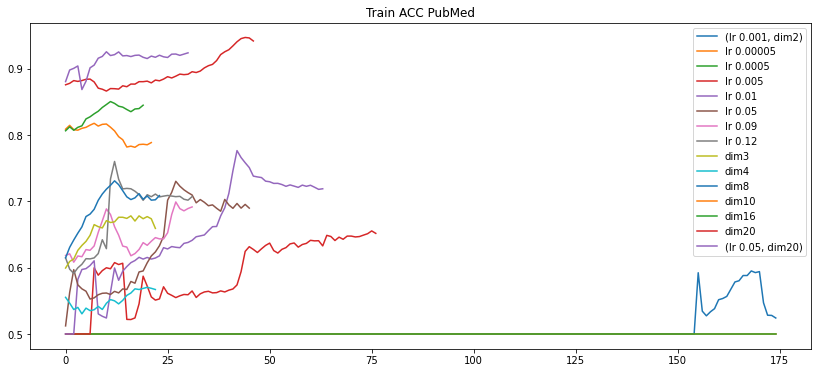

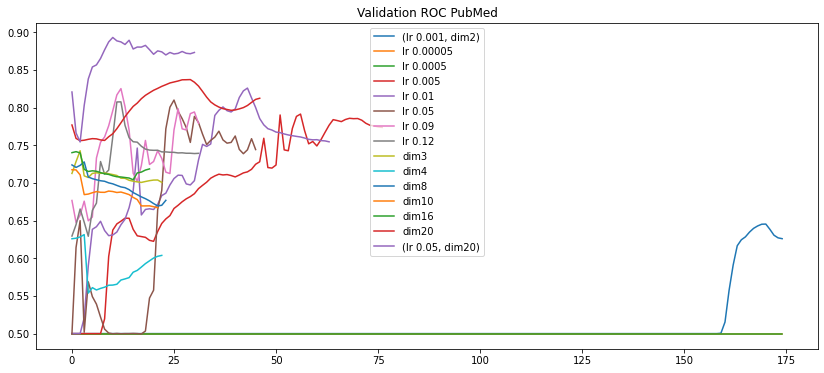

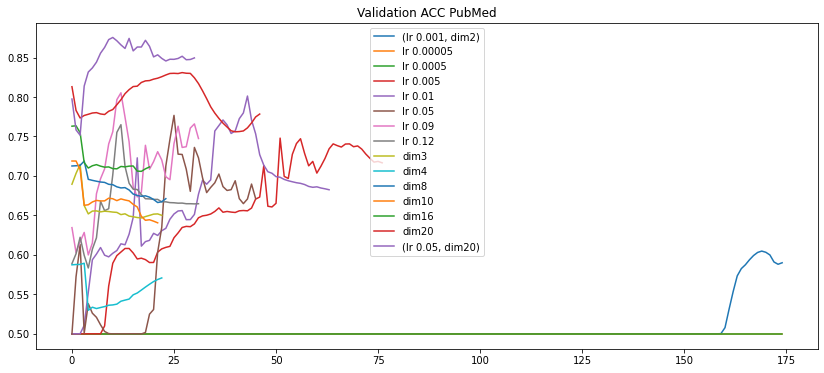

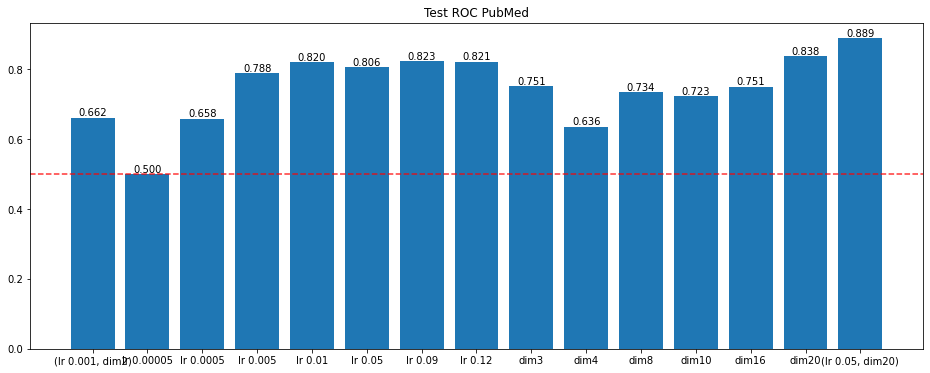

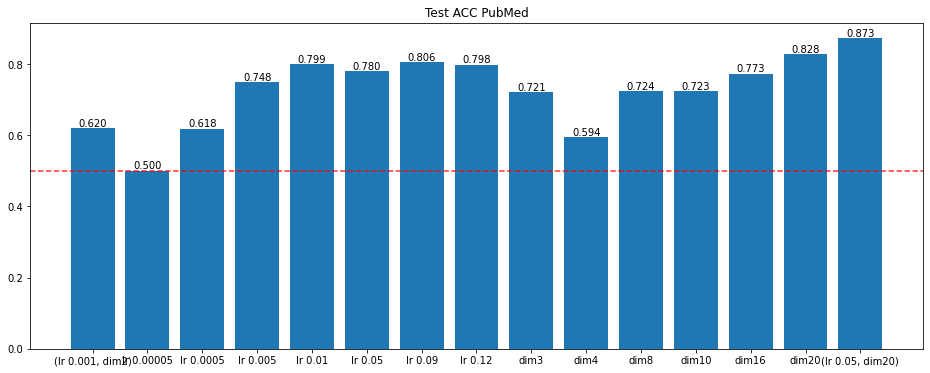

In [29]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc2, all_train_ap2, all_val_roc2, all_val_ap2]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=pub[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(pub, all_test_roc2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(pub, all_test_ap2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

# Confronto diretto HGCN vs GCN

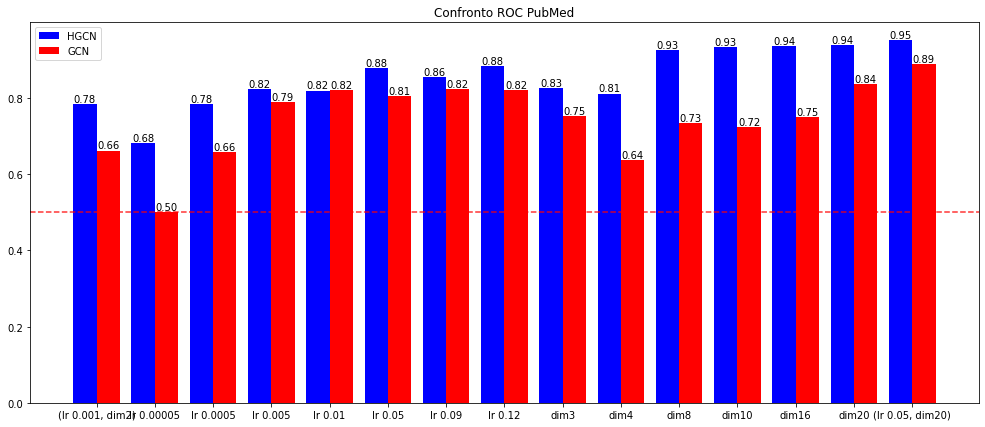

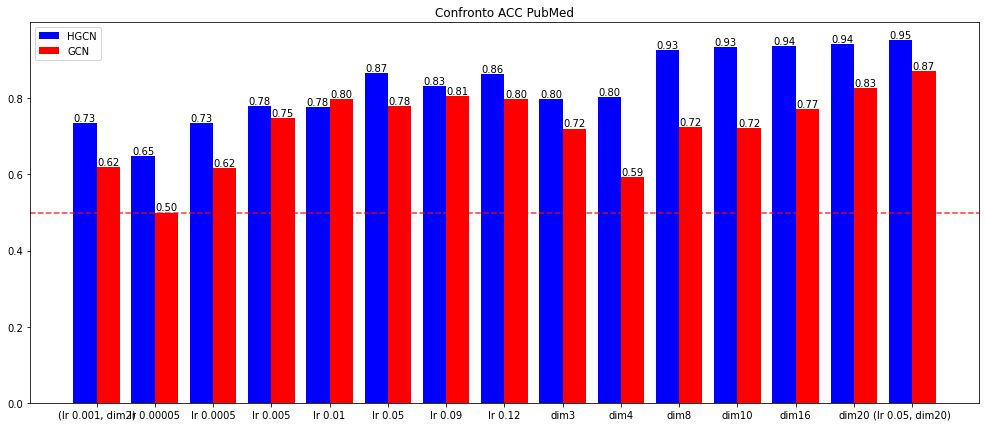

In [30]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(pub))
width = 0.4

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ROC " + dataset)

bars1 = plt.bar(x - width/2, all_test_roc, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_roc2, width, label='GCN', color='red')

plt.xticks(x, pub)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.show()

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ACC " + dataset)

bars1 = plt.bar(x - width/2, all_test_ap, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_ap2, width, label='GCN', color='red')

plt.xticks(x, pub)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.show()

In [31]:
z1 = []
z2 = []

for a, b in zip(all_test_ap, all_test_ap2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z1.append(diff_percent)
    else:
        print("Errore: divisione per zero")

for a, b in zip(all_test_roc, all_test_roc2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z2.append(diff_percent)
    else:
        print("Errore: divisione per zero")

print(f"La percentuale di guadagno di HGCN rispetto a GCN è:\n-Su ACC: {np.mean(z1):.2f}%\n-Su ROC: {np.mean(z2):.2f}%")
print(f"\nMaggior guadagno:\n-ACC: {pub[np.argmin(z1)]}\n-ROC: {pub[np.argmin(z2)]}")
print(f"\nMinor guadagno:\n-ACC: {pub[np.argmax(z1)]}\n-ROC: {pub[np.argmax(z2)]}")

La percentuale di guadagno di HGCN rispetto a GCN è:
-Su ACC: -12.98%
-Su ROC: -12.86%

Maggior guadagno:
-ACC: dim4
-ROC: lr 0.00005

Minor guadagno:
-ACC: lr 0.01
-ROC: lr 0.01


# Usando HGCN albero artificiale (balanced tree con r=3 e p=6, 1093 nodi e 1092 archi)

## Con le features che avevo usato all'inizio
### Non molto simbolico dato che presenta data leakage

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Albero artificiale HGCN"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_7_treeHGCN"

all_train_roc, all_train_ap = [], []
all_val_roc, all_val_ap = [], []
all_test_roc, all_test_ap = [], []

for i in range(len(special)):  # cartelle da 0 a 10
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", special[i], "\033[0m")
    out = print_metrics(log, False)
    

    all_train_roc.append(out[0])
    all_train_ap.append(out[1])
    all_val_roc.append(out[2])
    all_val_ap.append(out[3])
    all_test_roc.append(out[4])
    all_test_ap.append(out[5])

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    embeddings = np.load(embeddings_path)
    
    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

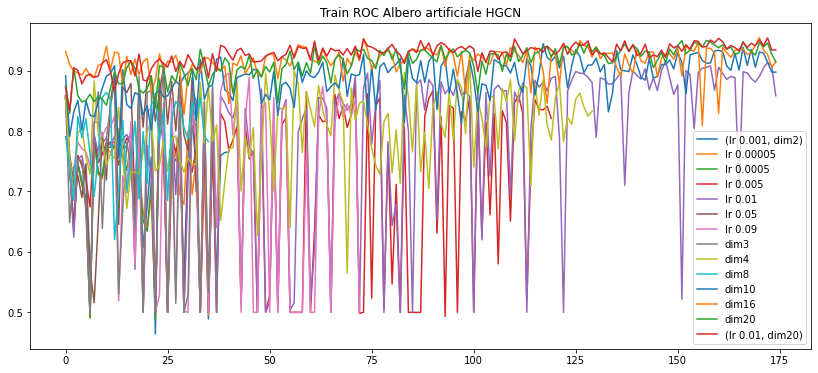

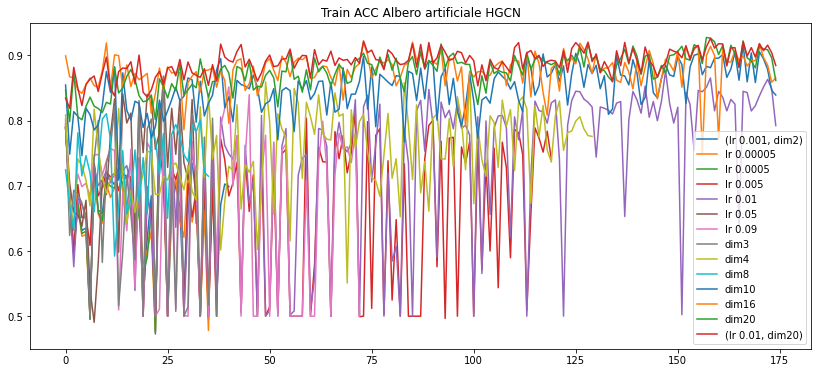

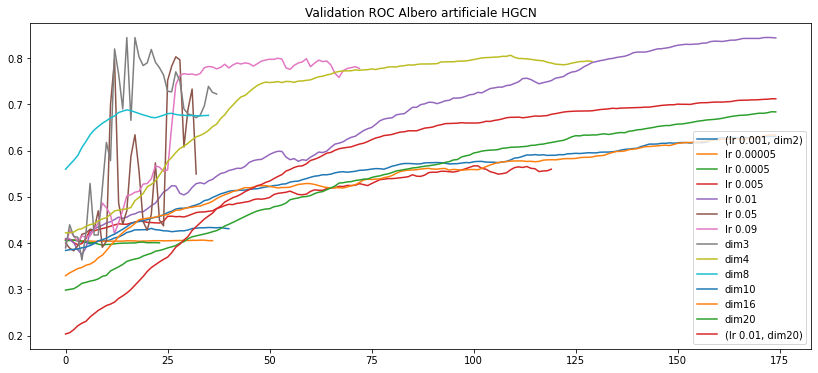

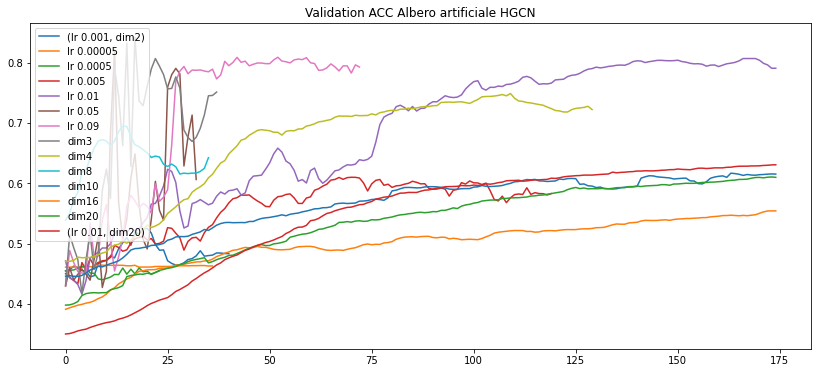

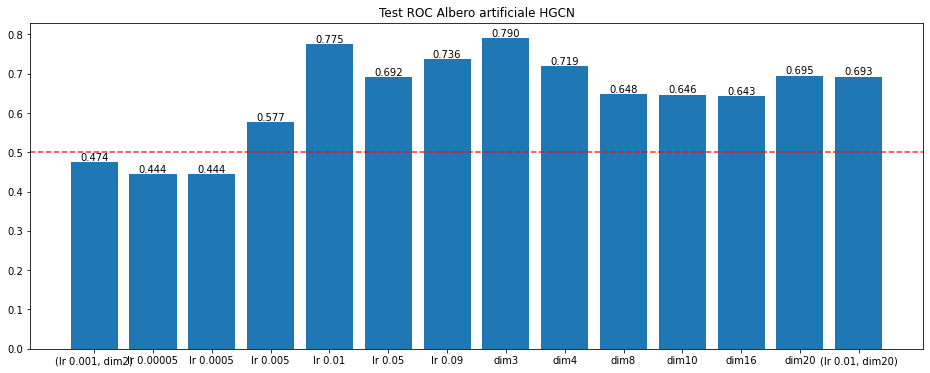

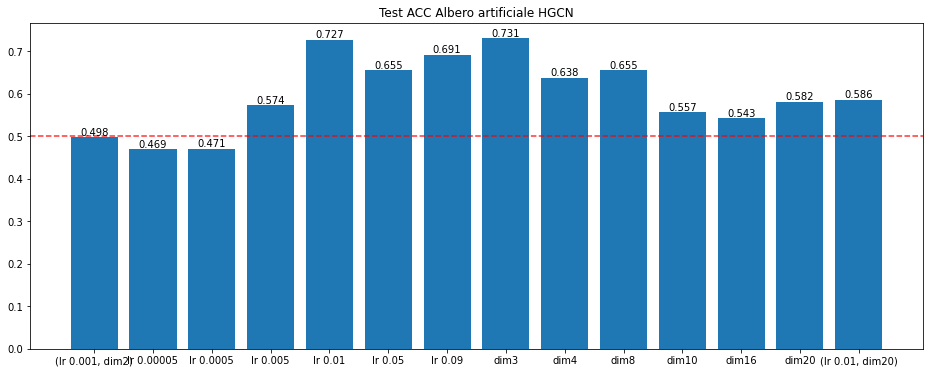

In [33]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc, all_train_ap, all_val_roc, all_val_ap]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=special[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(special, all_test_roc)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(special, all_test_ap)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

dataset = "Albero artificiale"
root_dir = "C:/Users/Lenovo/Desktop/1TESI MAGISTRALE/gridsearch/2025_12_7_treeGCN"

all_train_roc2, all_train_ap2 = [], []
all_val_roc2, all_val_ap2 = [], []
all_test_roc2, all_test_ap2 = [], []

for i in range(len(special)):
    folder_path = os.path.join(root_dir, str(i))
    embeddings_path = os.path.join(folder_path, "embeddings.npy")
    log = os.path.join(folder_path, "log.txt")

    if not os.path.exists(folder_path):
        print(f"Cartella {folder_path} non trovata, salto.")
        continue
    
    with open(log, "r") as f:
        cmd = f.readline().strip()
    
    print(cmd)
    print("\033[1m", special[i], "\033[0m")
    out = print_metrics(log, False)
    

    all_train_roc2.append(out[0])
    all_train_ap2.append(out[1])
    all_val_roc2.append(out[2])
    all_val_ap2.append(out[3])
    all_test_roc2.append(out[4])
    all_test_ap2.append(out[5])

    if not os.path.isfile(embeddings_path):
        print(f"File embeddings.npy non trovato in {folder_path}\n")
        continue
    embeddings = np.load(embeddings_path)
    
    # Plot
    plt.figure(figsize=(8,5))
    circle = plt.Circle((0,0), 1, color='black', fill=False)
    plt.gca().add_artist(circle)
    if len(embeddings.shape) == 1:
        # Caso array 1D
        plt.plot(embeddings)
        plt.title(f"embeddings.npy nella cartella {i} (1D)")
    elif len(embeddings.shape) == 2 and embeddings.shape[1] == 2:
        plt.scatter(embeddings[:, 0], embeddings[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (2D scatter)")
    else:
        pca = PCA(n_components=2)
        embeddings_pca = pca.fit_transform(embeddings)
        
        plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1])
        plt.title(f"embeddings.npy nella cartella {i} (shape {embeddings.shape})")

    plt.show()
    print("-------------------------------------------------------------------------------------------------------------------")

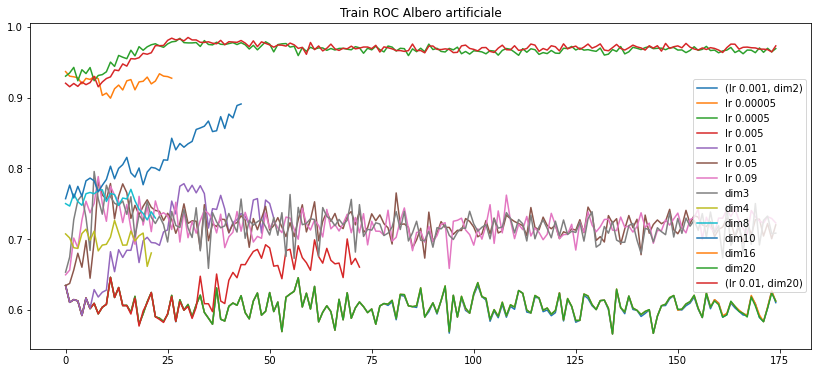

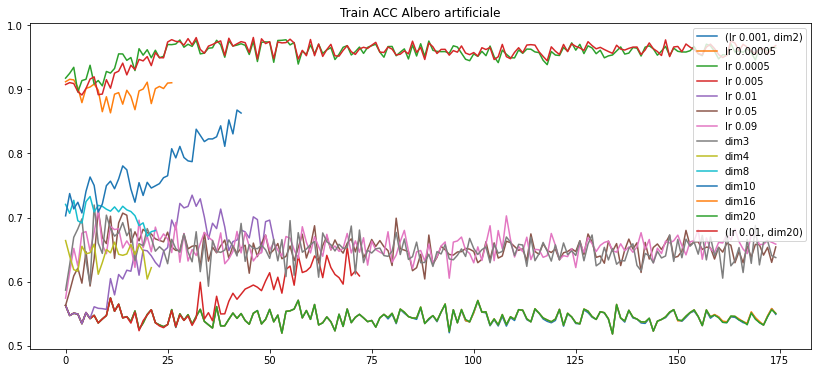

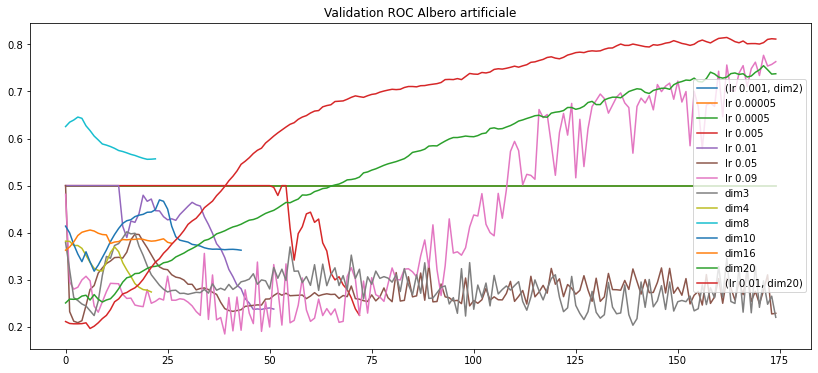

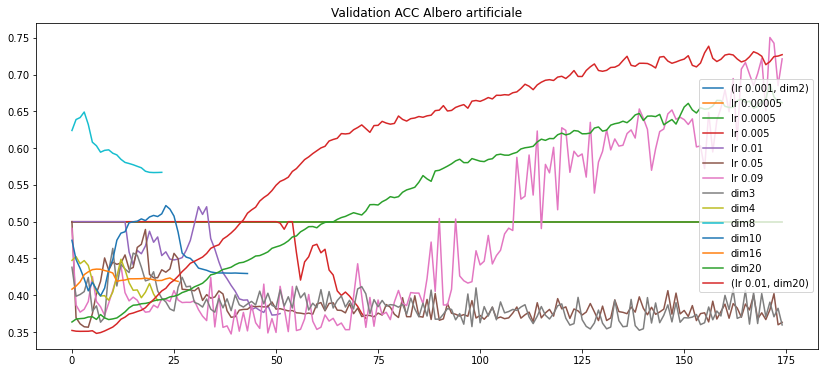

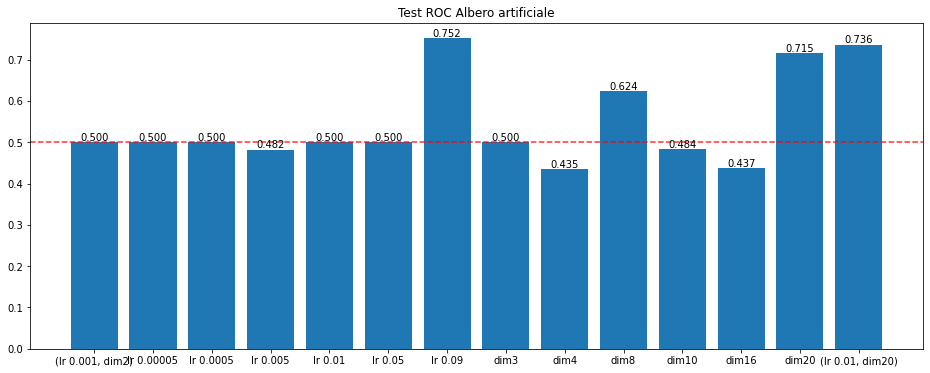

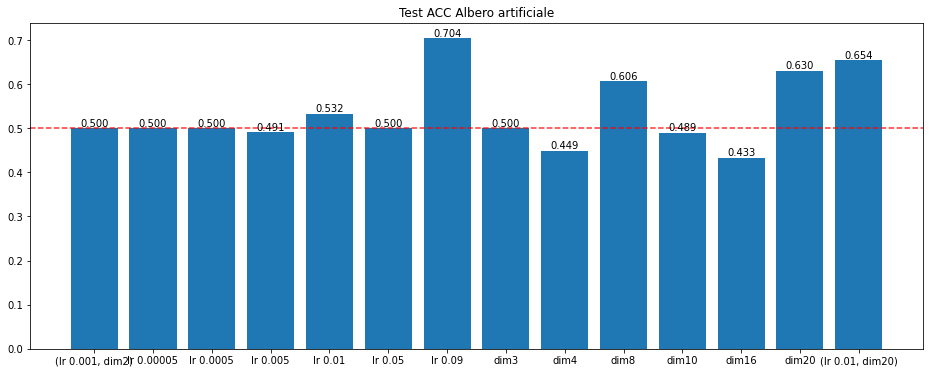

In [35]:
names = ["Train ROC", "Train ACC", "Validation ROC", "Validation ACC"]
lista = [all_train_roc2, all_train_ap2, all_val_roc2, all_val_ap2]

stampa = True

if stampa:
    for j in range(len(names)):
        plt.figure(figsize=(14, 6))
        plt.title(names[j]+ " " + dataset)

        for i in range(len(lista[j])):
            plt.plot(lista[j][i][:175], label=special[i])

        plt.legend()
        plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ROC" + " " + dataset)

    bars = plt.bar(special, all_test_roc2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,   # posizione x
            height,                              # posizione y
            f"{height:.3f}",                     # testo (3 decimali)
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

    plt.figure(figsize=(16, 6))
    plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
    plt.title("Test ACC" + " " + dataset)

    bars = plt.bar(special, all_test_ap2)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha='center', va='bottom', fontsize=10
        )

    plt.show()

# Confronto diretto HGCN vs GCN

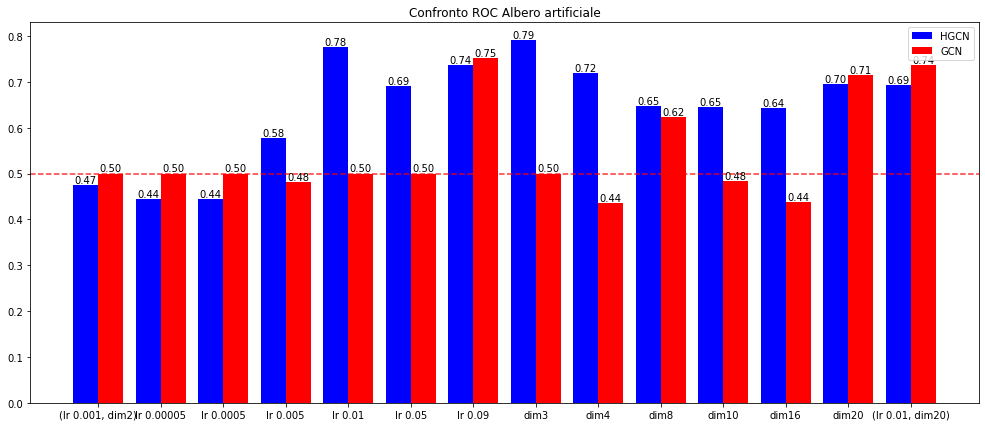

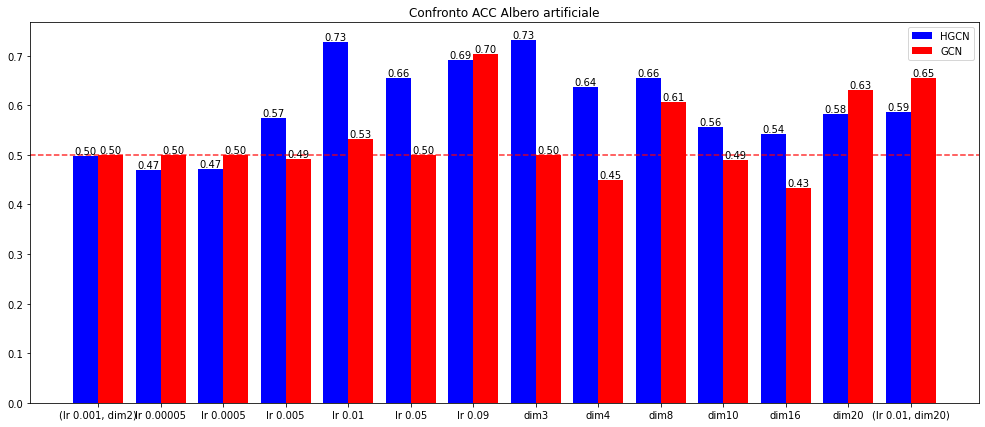

In [36]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(special))
width = 0.4

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ROC " + dataset)

bars1 = plt.bar(x - width/2, all_test_roc, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_roc2, width, label='GCN', color='red')

plt.xticks(x, special)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.show()

plt.figure(figsize=(17, 7))
plt.axhline(0.5, color='red', linestyle='--', alpha=0.8)
plt.title("Confronto ACC " + dataset)

bars1 = plt.bar(x - width/2, all_test_ap, width, label='HGCN', color='blue')
bars2 = plt.bar(x + width/2, all_test_ap2, width, label='GCN', color='red')

plt.xticks(x, special)
plt.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.show()

In [37]:
z1 = []
z2 = []

for a, b in zip(all_test_ap, all_test_ap2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z1.append(diff_percent)
    else:
        print("Errore: divisione per zero")

for a, b in zip(all_test_roc, all_test_roc2):
    if a != 0:
        diff_percent = (b - a) / a * 100
        z2.append(diff_percent)
    else:
        print("Impossibile calcolare percentuale: divisione per zero")

print(f"La percentuale di guadagno di HGCN rispetto a GCN è:\n-Su ACC: {np.mean(z1):.2f}%\n-Su ROC: {np.mean(z2):.2f}%")
print(f"\nMaggior guadagno:\n-ACC: {special[np.argmin(z1)]}\n-ROC: {special[np.argmin(z2)]}")
print(f"\nMinor guadagno:\n-ACC: {special[np.argmax(z1)]}\n-ROC: {special[np.argmax(z2)]}")

La percentuale di guadagno di HGCN rispetto a GCN è:
-Su ACC: -9.34%
-Su ROC: -12.49%

Maggior guadagno:
-ACC: dim3
-ROC: dim4

Minor guadagno:
-ACC: (lr 0.01, dim20)
-ROC: lr 0.00005
